# House Price Kaggle Competition

The [House Pricing](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) competition in Kaggle site is from a Getting Started category, it had opened in Aug 2016 and will be closed in Mar 2020.

The Ames (Iowa, USA) Housing dataset is a dataset of houses that were sold between the years 2006-2010, and consist of 79 independent features (+id), each one describes an attribute of the house structure, environment, saling conditions and others, as well as a dependent variable which is the sale price.

**The purpose of the project is to predict the sale price for each house, using regression techniques.**

**Project evaluation** is done by the Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. 

<a id='content'></a>
## Main Steps:
- [**Data Examination**](#Data Examination): Understanding the main contributing features, examining relationship between the features to the price and between featres and examining potential outliers.


- [**Filling Missing Values**](#Filling Missing Values): Using the description file to fill missing values, different approach for each feature.


- [**Feature Engineering**](#Feature Engineering): Make changes to the dataset, adding and modifying features.


- [**Modeling**](#Modeling): Trying various combinations of models, hyperparameters, number of features etc.


- [**Result Summary**](#Result Summary): Present results and benchmark.

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import patches
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.feature_selection import RFE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score, mutual_info_score, mean_squared_log_error
from sklearn.metrics import explained_variance_score
from sklearn.decomposition import PCA
from sklearn.base import TransformerMixin
from scipy import stats 
from scipy.stats import randint as sp_randint
from tqdm import tqdm_notebook as tqdm
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
import seaborn as sns; sns.set()
import math
import datetime
from xgboost import XGBRegressor
from mlxtend.regressor import StackingCVRegressor
%matplotlib inline

<a id='Data Examination'></a>
## Data Examination
[Back to top](#content)

In [2]:
train_data = pd.read_csv("train_copy.csv")
# I am reading the test file so it can be modified in the pipeline
test_data = pd.read_csv("test_copy.csv") 
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

First thing I see that I have 81 columns (the last one SalePrice is the dependent varaible), with mixed dtypes: int, float and object.

I also see that there are 1460 rows. This is a very small dataset, so I don't split it to train and dev, to have enough data for training, and instead I will exaimne result with cross validation.

In [4]:
# I check if there are any duplicates in the train_data
train_data.duplicated().sum()

0

No duplicates

### Dependent Variable

Minimum value of SalePrice is 34900
Maximum value of SalePrice is 755000


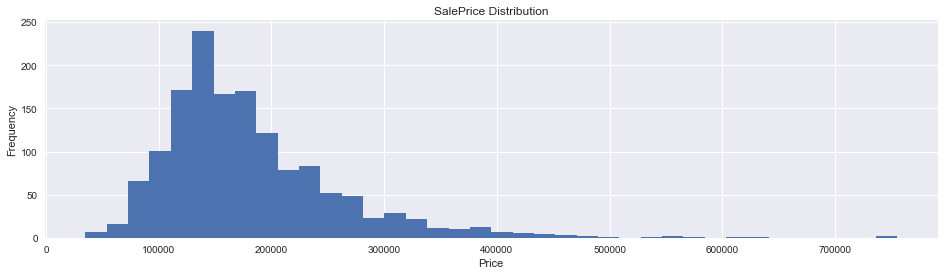

In [5]:
# First a glimpse of the SalePrice
print("Minimum value of SalePrice is {}".format(train_data["SalePrice"].min()))
print("Maximum value of SalePrice is {}".format(train_data["SalePrice"].max()))
# I am calculating the sqrt of the total observations as a rule of thumb for the number of bins
n_bins = int(round(np.sqrt(len(train_data)),0))
plt.figure(figsize=(16,4))
plt.hist(train_data["SalePrice"], bins=n_bins)
plt.title("SalePrice Distribution")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

I see that the data is skewed with a long "tail" to the right. There are also some extreme values I will examine later.

### Features

To start with I want to make a high level screening of the variables' importance to get a taste of the association with SalePrice. I am using the random forest regressor method feature_importances.
To do that I need to do the following steps:
1. Add numeric values for the string features. I am writing my own code because I want it to be ordered by category, i.e. the column's categories will get higher number if their average price is higher.
2. Selecting the columns with very high rate of nulls and removing them for now (just for this high level examination).
3. Droping nulls from the data.

In [6]:
# This cell is for adding numeric columns for the object features
for column in train_data:
    # The following if statement distinguishes between an object column (string) and a numeric. Takes only object
    if train_data[column].dtype == object:
        mean_target = train_data.groupby(column)["SalePrice"].mean() # Finds the mean of each group
        mean_target.sort_values(inplace=True)
        idx_dict = {} # This dictionary keeps all the categories (values) of the feature and its mean SalePrice 
        for index in mean_target.index:
            idx_dict[index] = mean_target.index.get_loc(index) # Assigning values to each key in the dictionary
        train_data[column+"_num"] = train_data[column].map(idx_dict) # Add the column

In [7]:
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,GarageType_num,GarageFinish_num,GarageQual_num,GarageCond_num,PavedDrive_num,PoolQC_num,Fence_num,MiscFeature_num,SaleType_num,SaleCondition_num
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,4.0,1.0,2.0,4.0,2,NaN,NaN,NaN,4,4
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,4.0,1.0,2.0,4.0,2,NaN,NaN,NaN,4,4
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,4.0,1.0,2.0,4.0,2,NaN,NaN,NaN,4,4
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,1.0,0.0,2.0,4.0,2,NaN,NaN,NaN,4,1
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,4.0,1.0,2.0,4.0,2,NaN,NaN,NaN,4,4


I see that the numeric columns were added

In [8]:
# I am selecting the columns to be removed for this step
threshold_to_drop = 500 # Max nulls
columns_to_drop = []
for column in train_data:
    # If the column has nulls more than the threshold, it will be added to the columns_to_drop list
    if train_data[column].isnull().sum() > threshold_to_drop:
        columns_to_drop.append(column)
# Since I want only the independent variables I am droping also the SalePrice
columns_to_drop.append("SalePrice")
columns_to_drop

['Alley',
 'FireplaceQu',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'Alley_num',
 'FireplaceQu_num',
 'PoolQC_num',
 'Fence_num',
 'MiscFeature_num',
 'SalePrice']

In [9]:
# Generation X and y
X = train_data.drop(columns_to_drop, axis=1)
y = train_data["SalePrice"]
# I am uniting the X and y to drop the NaNs, and spliting back afterwards
Xy = X.join(y)
Xy = Xy.dropna()
X=Xy.drop(["SalePrice"], axis=1)
y=Xy["SalePrice"]

In [10]:
# I am checking how many rows are left after the NaN droping. This is now the subset I will examine in high level
len(X)

1094

It is around 75% of the train_data which is OK for me.

In [11]:
# Taking out the object features
for column in X:
    if train_data[column].dtype == object:
        X = X.drop(column, axis=1)

In [12]:
list_of_columns = X.columns
regressor = RandomForestRegressor(n_estimators = 20, random_state = 0, max_depth=9, min_samples_leaf=1)
regressor.fit(X, y)
importance = regressor.feature_importances_
# The list of importances comes as an array with no labels, so I match the list_of_columns to get the feature for each value
list_of_importance_tups = list(zip(list_of_columns, importance))
# Now I sort it because I want them ordered by their importance
sorted_importance = sorted(list_of_importance_tups, key=lambda x: x[1], reverse=False)
feature_importance_df = pd.DataFrame(sorted_importance, columns=["feature", "corr"])
feature_importance_df

,feature,corr
0,Street_num,0.000000
1,Utilities_num,0.000000
2,GarageCond_num,0.000000
3,Heating_num,0.000004
4,Condition2_num,0.000004
5,RoofMatl_num,0.000018
6,MiscVal,0.000046
7,GarageQual_num,0.000060
8,Foundation_num,0.000065
9,Electrical_num,0.000094


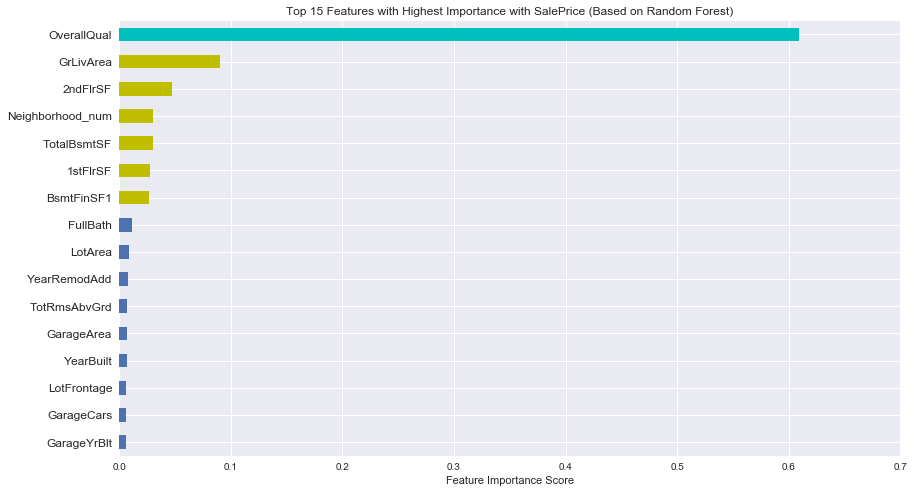

In [13]:
# Now plotting
n_bar = 15 # Number of features in the plot

fig1 = plt.figure()
ax1 = fig1.gca()
feature_bar_plot = feature_importance_df[-(n_bar+1):].plot.barh(ax=ax1, figsize=(14,8)) # The last feature is the SalePrice,
                                                                                        #so I left it out
ax1.set_yticklabels(feature_importance_df["feature"][-(n_bar+1):], fontsize=12) # Get the names of the feature
ax1.set_xlim(0,0.7)
ax1.grid(True)
ax1.set_title("Top {} Features with Highest Importance with SalePrice (Based on Random Forest)".format(n_bar))
ax1.set_xlabel("Feature Importance Score")
# The following 4 lines are for coloring the features
n_feature_color = 6
for i in range(n_feature_color):
    ax1.patches[(n_bar-1)-i].set_facecolor('y')
ax1.patches[(n_bar)].set_facecolor('c')
plt.gca().get_legend().remove()
plt.show()

There are some insights from this view. 
1. The most important feature, much than the others is **OverallQual** (cyan color)
2. Then, 5 of the next 6 features (higer than 0.02, colored yellow) are **area related features**
3. Next, ** Neighborhood_num** is also one of the leading features
4. Most of the other features also indicate importance of area

I still need to further investigate the relationship within the area related features, and between these to the OverallQual and Neighborhood, but it seems as if these three play a major role in determining the price.

<a id='area_heatmap'></a>
Now I am examining the correlation between the area related features in the Top 15.

[Link to LotFrontage](#LotFrontage)

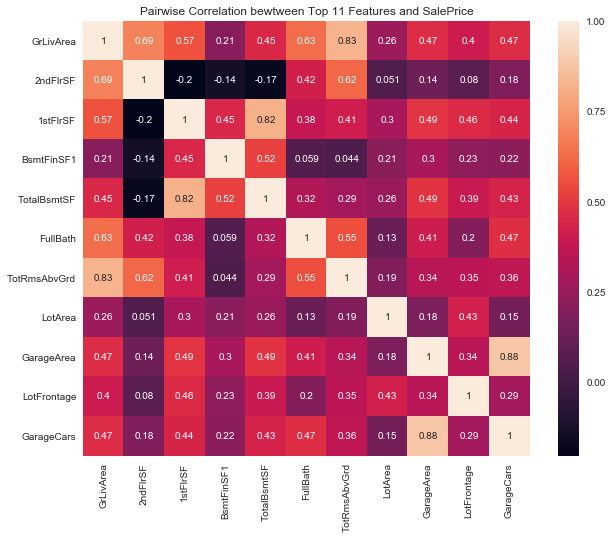

In [14]:
area_features_from_top_15 = ["GrLivArea", "2ndFlrSF", "1stFlrSF", "BsmtFinSF1", "TotalBsmtSF" ,"FullBath", "TotRmsAbvGrd", \
                             "LotArea", "GarageArea", "LotFrontage", "GarageCars"]  
# The following line creates a pairwise matrix of correlation
df_for_heatmap = train_data[area_features_from_top_15].corr()
# I need to take out the NaNs so I don't get an error
df_for_heatmap = df_for_heatmap.fillna(value=np.nan)
heatmap_size=len(area_features_from_top_15) # Counts the features - I need this for the title
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(df_for_heatmap, annot=True)
ax.set_title('Pairwise Correlation bewtween Top {} Features and SalePrice'.format(heatmap_size))
plt.show()

Insights fron the heatmap:
1. In general, there is high level of correlation between some of the area realted features (the heatmap is orange-like)
2. 1stFlrSF and 2ndFlrSF are not correlated, but both of them are in high correlation to the GrLivArea (area above ground), so they seem to be redundant. Also GrLivArea is comprised of these features.
3. TotRmsAbvGrd	(total rooms above ground) is highly correlated with the above GrLivArea, and that makes a lot of sense, this also seems redundant.
4. Full bath (Full bathrooms above grade) - has some correlation with the GrLivArea, but it is not in SF but the number of baths. Any way these are not all the baths since there are also the half baths, so they need to get separate treatment in the feature engineering.
5. TotalBsmtSF correlates well with the first floor area (makes sense), and has lower correlation with the GrLivArea. It seems as if I need to add it to the GrLivArea to get the full area.
6. LotArea has lower correlation with the house area features. It has some correlation to the LotFrontage (makes sense).
7. GarageCars and GarageArea are highly correlated, therefore one is redundant.

So, since 1stFlrSF and 2ndFlrSF are included in GrLivArea, the three main topics I identified are: OverallQual, Neighborhood, and the GrLivArea. Now I want to examine the correlation between the these main varuiables to identify potential redundancy.  

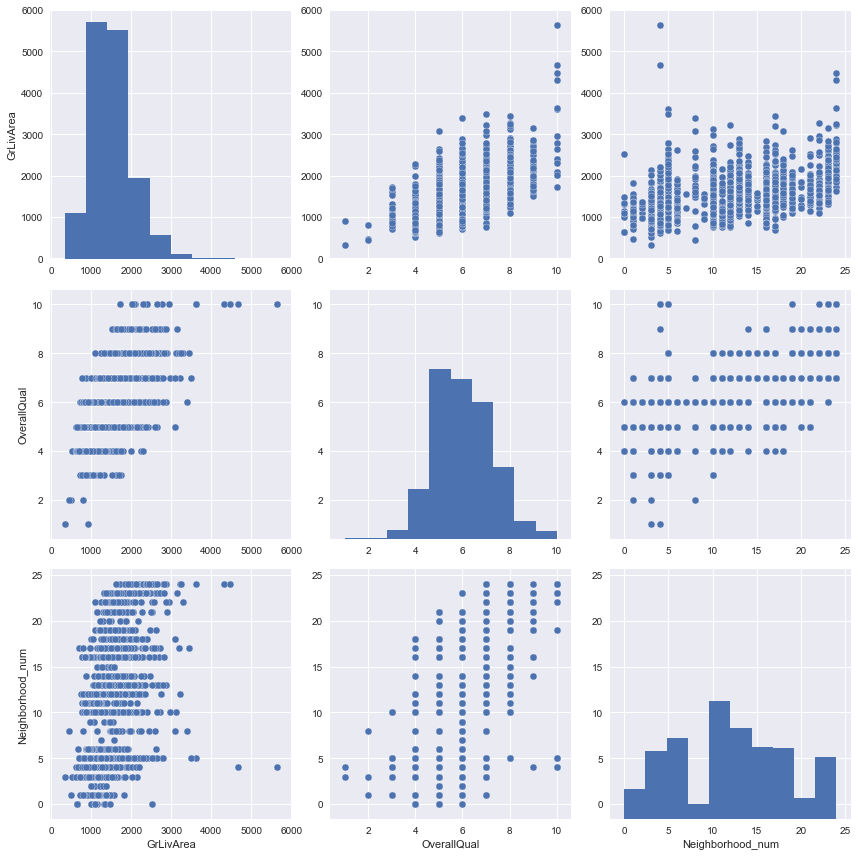

In [15]:
features_for_pair_plot = ["GrLivArea", "OverallQual", "Neighborhood_num"]
# I am creating this small dataframe to be inserted to the pairplot 
df_for_pair_plot = train_data[features_for_pair_plot]
sns.pairplot(df_for_pair_plot, size=4)
plt.show()

We see that there is some associaiton between OverallQual and Neighborhood_num (some neighborhoods are ranked with higher quality than others), and between OverallQual and GrLivArea, but it is vague enough to allow us use all three of them. Now I will examine each of these variables against the SalePrice:

**OverallQual against SalePrice**

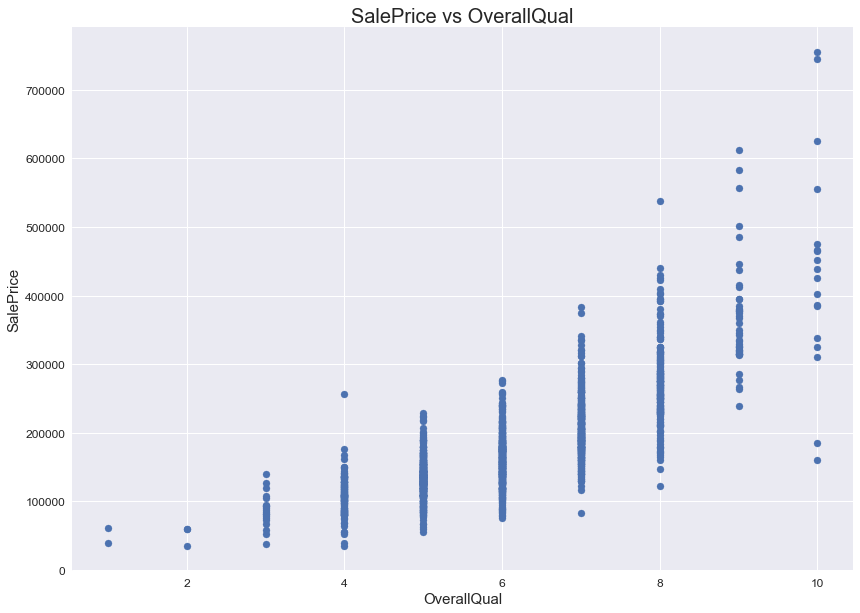

In [16]:
fig2 = plt.figure(figsize=(14,10))
ax2 = fig2.gca()
plt.scatter(train_data["OverallQual"], train_data["SalePrice"])
ax2.set_xlabel("OverallQual", fontsize=15)
ax2.set_ylabel("SalePrice", fontsize=15)
ax2.set_title("SalePrice vs OverallQual",fontsize=20)
ax2.tick_params(axis='both', which='major', labelsize=12)
plt.show()

Most quality levels are spread out nicely on a range of prices. We see the clear association

**GrLivArea against SalePrice**

In [17]:
# This cell was created originally after I drew the plot and saw the outliers. Then I moved it back to use the coordinates in 
# the plot
condition_for_slicing = (train_data["GrLivArea"] > 4000) | (train_data["SalePrice"] > 700000) # condition covers the 4 points
grlivarea_saleprics_outliers = train_data[condition_for_slicing] # Full data only for the 4 points
outliers_for_plot = grlivarea_saleprics_outliers[["GrLivArea", "SalePrice"]]
outliers_for_plot

,GrLivArea,SalePrice
523,4676,184750
691,4316,755000
1182,4476,745000
1298,5642,160000


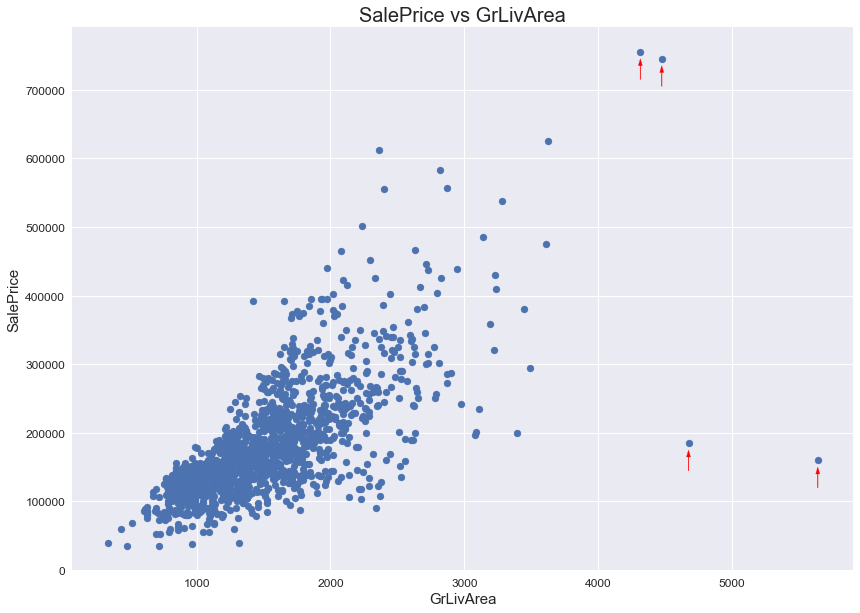

In [18]:
fig3 = plt.figure(figsize=(14,10))
ax3 = fig3.gca()
plt.scatter(train_data["GrLivArea"], train_data["SalePrice"])
ax3.set_xlabel("GrLivArea", fontsize=15)
ax3.set_ylabel("SalePrice", fontsize=15)
ax3.set_title("SalePrice vs GrLivArea",fontsize=20)
ax3.tick_params(axis='both', which='major', labelsize=12)
# The following for loop runs through the potential outliers, and for each creates an arrow based on the point's coordinates
for i in range(len(outliers_for_plot)):
    x_base =outliers_for_plot.iloc[i,0]
    y_base = outliers_for_plot.iloc[i,1] - 40000
    ax3.arrow(x_base,y_base, 0, 20000, color='r', width=4, head_width=30, head_length=10000)
plt.show()

This shows the correlation.

Also there are some potential outliers (with red markers). I have two outliers on the bottom right, also two other potential outliers above 700K.

In [19]:
# I am slicing the outlier data by the most important features to compare with other similar points
grlivarea_saleprics_outliers[["SalePrice", "GrLivArea", "OverallQual", "Neighborhood_num"]]

,SalePrice,GrLivArea,OverallQual,Neighborhood_num
523,184750,4676,10,4
691,755000,4316,10,24
1182,745000,4476,10,24
1298,160000,5642,10,4


First I deal with the two outliers on the bottom right (index 523 and 1298). I see that in addition to having very large area, they also have OverallQual of 10, and they are in Neighborhood 4 (reletively low prices. I want to see all the other houses in this segment, and see if this is uniuqe (outliers) or not. I will slice all the houses in Neighborhood_num=4 and OverallQual >6:

In [20]:
train_data[(train_data.Neighborhood_num == 4) & (train_data.OverallQual > 6)][["GrLivArea", "OverallQual", "SalePrice", "Id"]]

,GrLivArea,OverallQual,SalePrice,Id
193,1709,7,130000,194
362,1922,7,198500,363
523,4676,10,184750,524
724,1698,9,320000,725
1088,1709,7,137500,1089
1254,1656,7,165400,1255
1298,5642,10,160000,1299
1304,1708,7,130000,1305


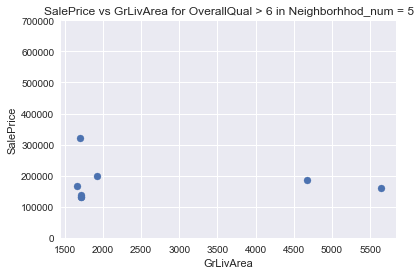

In [21]:
cond1 = train_data.Neighborhood_num == 4
cond2 = train_data.OverallQual > 6
high_qual_houses_in_neighborhood_5 = train_data[(cond1) & (cond2)][["GrLivArea", "OverallQual", "SalePrice"]]
# I am plotting the houses only in neighborhood 5, above quality 6 
plt.scatter(high_qual_houses_in_neighborhood_5["GrLivArea"], high_qual_houses_in_neighborhood_5["SalePrice"])
plt.title("SalePrice vs GrLivArea for OverallQual > 6 in Neighborhhod_num = 5")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.ylim(0,700000)
plt.show()

We would expect that these two houses will cost more because the area is significantly bigger, and also they are with quality of 10, all the other haouses are with quality 7. Since they cost relatively the same, I conclude that they are outliers. I will remove them:

In [22]:
train_data = train_data[(train_data["Id"] != 1299) & (train_data["Id"] != 524)]
# Now I will check that the number of rows to make sure
train_data.shape[0] 

1458

I contintue with the point above 700K. These are relatively big housea, high quality and in expensive neighborhood (24). Let's see all the houses with similar characteristics:

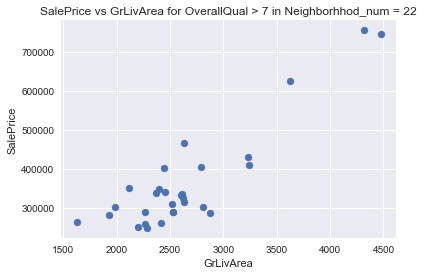

In [23]:
cond1 = train_data.Neighborhood_num == 24 
cond2 = train_data.OverallQual > 7
high_qual_houses_in_neighborhood_22 = train_data[(cond1) & (cond2)][["GrLivArea", "OverallQual", "SalePrice"]]
# I am plotting the houses only in neighborhood 22, above quality 7 
plt.scatter(high_qual_houses_in_neighborhood_22["GrLivArea"], high_qual_houses_in_neighborhood_22["SalePrice"])
plt.title("SalePrice vs GrLivArea for OverallQual > 7 in Neighborhhod_num = 22")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()

This points follow the pattern of the other houses so they are **not** outliers

**Neighorhood_num against SalePrice**

In [24]:
# Calculating the mean and median for every neighborhood
Neighborhood_mean = train_data.groupby("Neighborhood_num")["SalePrice"].mean()
Neighborhood_median = train_data.groupby("Neighborhood_num")["SalePrice"].median()

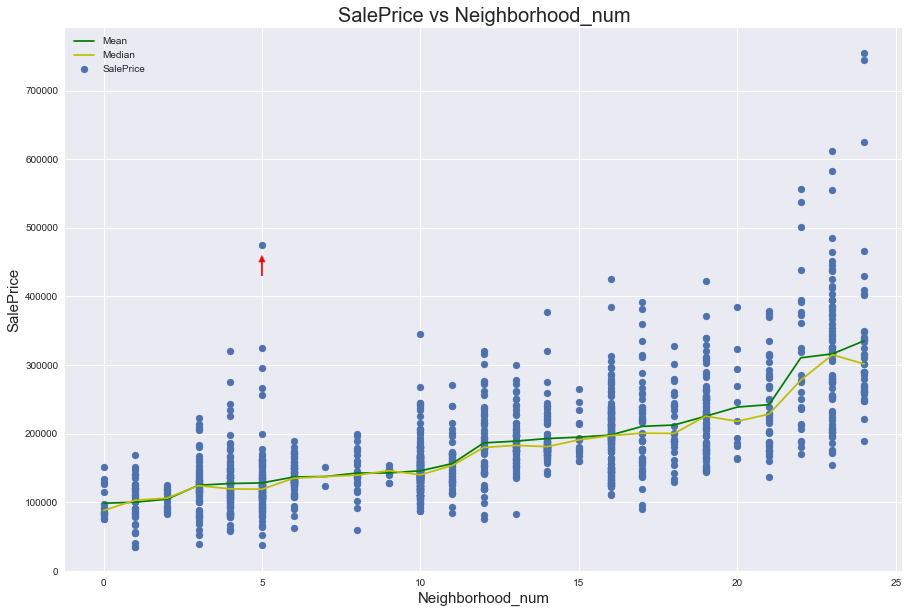

In [25]:
fig4 = plt.figure(figsize=(15,10))
ax4 = fig4.gca()
plt.scatter(train_data["Neighborhood_num"], train_data["SalePrice"])
plt.plot(Neighborhood_mean, "g", label="Mean")
plt.plot(Neighborhood_median, "y", label="Median")
ax4.set_ylabel("SalePrice", fontsize=15)
ax4.set_xlabel("Neighborhood_num", fontsize=15)
ax4.set_title("SalePrice vs Neighborhood_num",fontsize=20)
ax4.legend(loc='upper left')
# Adding an arrow for the potential outlier
ax4.arrow(5,430000, 0, 20000, color='r', width=0.05, head_width=0.2, head_length=10000)
plt.show()

The mean and medians are close in most of the neighborhoos - not much skew within each neighborhood

There is one potential point (with red arrow). I will explore it:

In [26]:
train_data[(train_data.SalePrice > 400000) & (train_data.Neighborhood_num == 6)][["OverallQual", "GrLivArea"]]

,OverallQual,GrLivArea


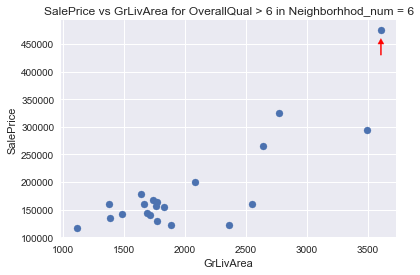

In [27]:
# First specifying the conditions for slicing the houses with similar characteristics
cond1 = train_data.Neighborhood_num == 5
cond2 = train_data.OverallQual > 6
# The creating the mini dataframe for the scatter
high_qual_houses_in_neighborhood_6 = train_data[(cond1) & (cond2)][["GrLivArea", "OverallQual", "SalePrice"]]
plt.scatter(high_qual_houses_in_neighborhood_6["GrLivArea"], high_qual_houses_in_neighborhood_6["SalePrice"])
plt.title("SalePrice vs GrLivArea for OverallQual > 6 in Neighborhhod_num = 6")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.arrow(3608,430000, 0, 20000, color='r', width=10, head_width=50, head_length=10000)
plt.show()

For big houses with high quality (this house was with quality of 10) the price makes sense. No outlier here.

### Quality Heatmap 

The idea here is to see if the quality related features are reflected in OverallQuality.

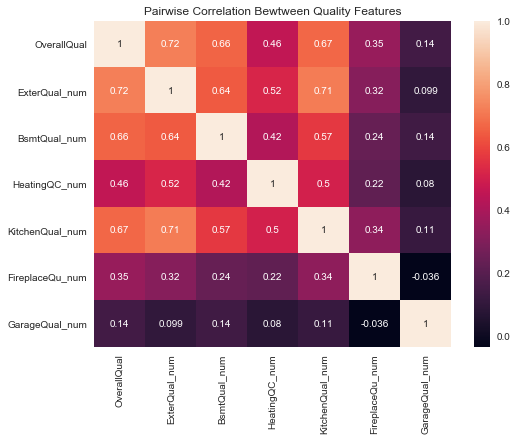

In [28]:
features_for_heatmap = ["OverallQual", "ExterQual_num", "BsmtQual_num", "HeatingQC_num", "KitchenQual_num", \
                        "FireplaceQu_num", "GarageQual_num"]  
# The following line creates a pairwise matrix of correlation
df_for_heatmap = train_data[features_for_heatmap].corr()
train_data[features_for_heatmap]
df_for_heatmap = df_for_heatmap.fillna(value=np.nan)
heatmap_size=len(features_for_heatmap)
f, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(df_for_heatmap, annot=True)
ax.set_title('Pairwise Correlation Bewtween Quality Features')
#sns.set(font_scale=30)
plt.show()

Insights: ExterQual, BsmtQual and KitchenQual are in correlation with OverQuall, and seem to be redundant.

HeatingQC and FireplaceQu are less corelated, and GarageQual has very little correlation.

At this point, I do not need the '_num'  features any more, since the categorical features will be encoded.

In [29]:
# I find the index of the SalePrice, and then I use it to drop all the other columns beyond it
saleprice_column_index = train_data.columns.get_loc("SalePrice")
train_data = train_data.drop(train_data.iloc[:, saleprice_column_index+1:].head(0).columns, axis=1)
# Makung sure I m back with the original number of columns
train_data.shape

(1458, 81)

<a id='Filling Missing Values'></a>
## Filling Missing Values
[Back to top](#content)

I will take care of each feature with missing values separately, since each one is different, unless there are features with commonality. I am going to use the data_description file to fill in the missing values. First I get the number of missing values per feature:

In [30]:
# I am printing separately becasue I want the to view all of the features (it does not display all if applied on all dataframe)
for feature in train_data:
    if train_data[feature].isnull().sum() != 0:
        print("{:20} {}".format(feature, train_data[feature].isnull().sum()))

LotFrontage          259
Alley                1367
MasVnrType           8
MasVnrArea           8
BsmtQual             37
BsmtCond             37
BsmtExposure         38
BsmtFinType1         37
BsmtFinType2         38
Electrical           1
FireplaceQu          690
GarageType           81
GarageYrBlt          81
GarageFinish         81
GarageQual           81
GarageCond           81
PoolQC               1452
Fence                1177
MiscFeature          1404


**LotFrontage** (259 missing values)

**LotFrontage: Linear feet of street connected to property**

Need to add:
    1. histogram of the data with and without nulls (+ average) - to show that it is not 0.
    2. Random division of the data and plot the corr of these groups.
    https://stackoverflow.com/questions/45938227/random-blocks-of-data-in-pandas

In [31]:
#train_data["SalePrice"][train_data["LotFrontage"].notnull()].mean()

The data_description file does not say if NA is 0 linear feet or no information. There is high percentage of missing values so I want to check whether to leave this feature or not. First I check the association with SalePrice.

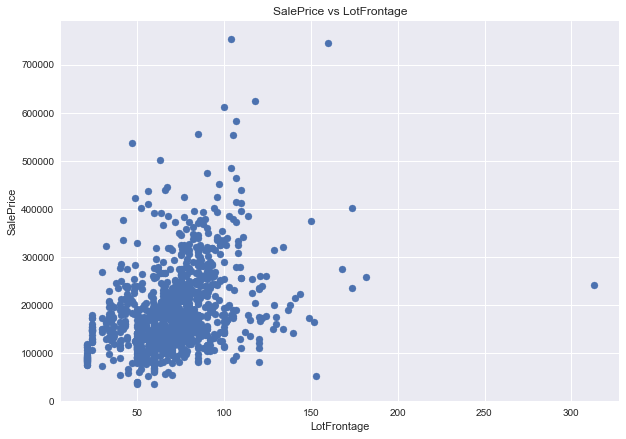

In [32]:
fig = plt.figure(figsize=(10, 7))
plt.scatter(train_data["LotFrontage"], train_data["SalePrice"])
plt.xlabel("LotFrontage")
plt.ylabel("SalePrice")
plt.title("SalePrice vs LotFrontage")
plt.show()

In [33]:
print("Correlation between LotFrontage and SalePrice is: {:.2f}.".format(train_data["LotFrontage"].corr(train_data["SalePrice"])))
print("LotFrontage mean is: {:.1f}".format(train_data["LotFrontage"].mean()))
print("LotFrontage median is: {}".format(train_data["LotFrontage"].median()))

Correlation between LotFrontage and SalePrice is: 0.37.
LotFrontage mean is: 69.8
LotFrontage median is: 69.0


I will also check if the samples with missing LotFrontage have different price, and then this could indicate if the missing values mean 0 frontage or that they are real missing values

Text(0.5,1,'SalePrice Distribution for Null LotFrontage vs Not-null LotFrontage')

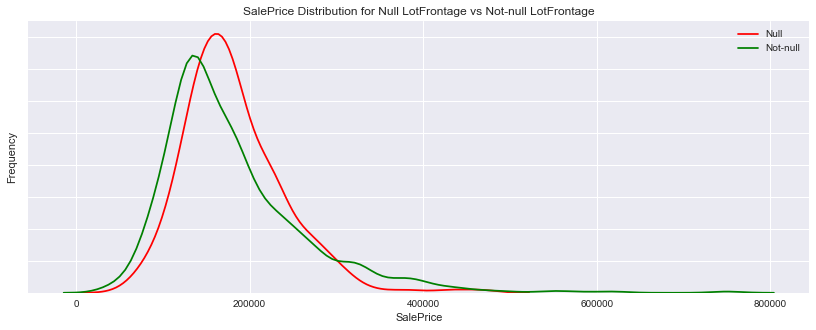

In [34]:
ax = plt.figure(figsize=(14,5)).gca()
funcs = [pd.isnull,pd.notnull]
labels = ["Null", "Not-null"]
colors = ["r", "g"]
for i in range(2):
    sns.distplot(train_data["SalePrice"][train_data["LotFrontage"].apply(funcs[i])], ax=ax, rug=False, hist=False, color=colors[i], label=labels[i])
ax.legend()
ax.set_yticklabels("")
ax.set_ylabel("Frequency")
ax.set_title("SalePrice Distribution for Null LotFrontage vs Not-null LotFrontage")

It seems that the SalePrice of the samples with null LotFrontage, are not lower than the SalePrice of those with data, they are even a bit higher. Anyway, since there is a positive correlation between the LotFrontage and SalePrice, as I saw in the previous plot, I assume that the null values in LotFrontage are not 0, and therefore I will try to predict them. 

Methodology for filling missing values in LotFrontage:



<a id='LotFrontage'></a>
The correlation of LotFrontage with **LotArea** is **0.43** as I saw [in the heatmap](#area_heatmap). On one hand thery are not correlated enogh to make some direct extrapulation from LotArea values, on the other hand I can do something with this partial correlation. I will try to find other variables, so that if I group by these variables I can find higher correlation within each group and use it to "predict" the LotFrontage by the LotArea feature (do a simple linear regression between LotFrontage and LotArea within each group).

First I need to examine the distribution of LotArea:

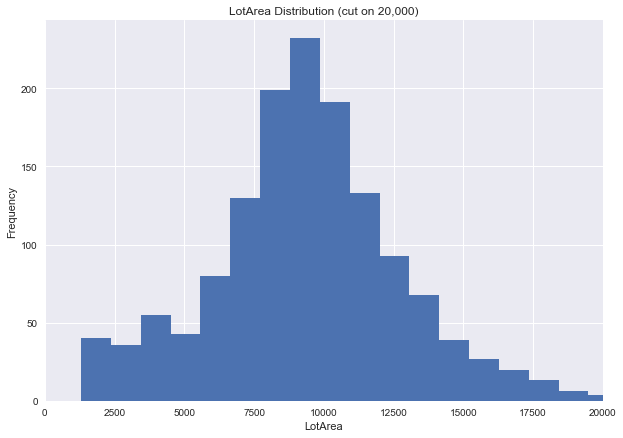

In [35]:
fig = plt.figure(figsize=(10, 7))
train_data["LotArea"].plot(kind='hist', bins=200)
plt.title('LotArea Distribution (cut on 20,000)')
plt.xlabel('LotArea')
plt.xlim(0,20000)
plt.show()

Most of the data is between 7500 and 12500, so I need to examine the other features' categories that fall in this range, I mean to see a differentiation within that range. For example, if I see that all of the categories are with average of 10,000, this will not help me, because there is no differentiation. 

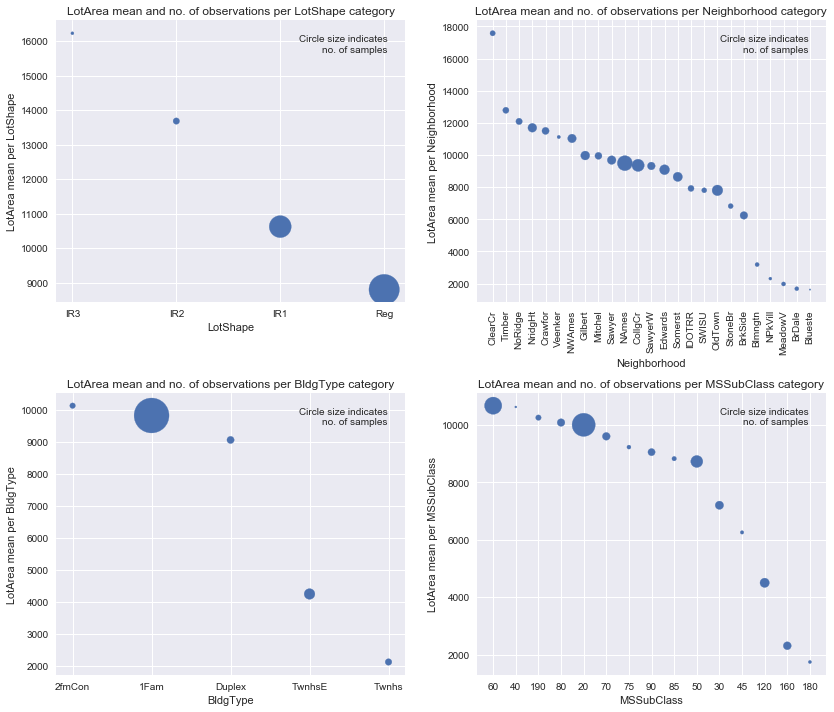

In [36]:
# The purpose of this cell is to try to find variables with high association with with LotArea. Since these are categorical 
# features, I am taking the median of LotArea for each group
fig = plt.figure(figsize=(12,10))
features = ["LotShape", "Neighborhood", "BldgType", "MSSubClass"]
for feature, i in zip(features, range(1,5)):
    # First creating a sorted groupby object 
    count_lotarea_median = train_data.groupby(feature).agg({feature:'count', "LotArea": 'median'})
    count_lotarea_median_sorted = count_lotarea_median.sort_values(by=["LotArea"], ascending=False) # Sort by the median value of the median
    count_lotarea_median_sorted["idx"] = count_lotarea_median_sorted.index
    count_lotarea_median_sorted["num"] = list(range(len(count_lotarea_median_sorted))) # Allowing drawing by the order
    category_num = len(count_lotarea_median_sorted)
    # Now ploting
    ax=fig.add_subplot(2,2,i)
    count_lotarea_median_sorted.plot.scatter(x="num", y="LotArea", ax=ax, s=count_lotarea_median_sorted[feature])
    ax.set_xlabel(feature)
    ax.set_ylabel("LotArea mean per {}".format(feature))
    ax.set_title("LotArea mean and no. of observations per {} category".format(feature))
    ax.set_xticks(np.arange(category_num))
    ax.set_xticklabels(count_lotarea_median_sorted["idx"])
    ax.text(0.95, 0.95, 'Circle size indicates\nno. of samples', horizontalalignment='right', verticalalignment='top', transform=ax.transAxes)
    # For the Neighborhood I rotate the xtick labels 
    if feature == "Neighborhood":
        for tick in ax.get_xticklabels():
            tick.set_rotation(90)
plt.tight_layout()

So what can we see?

For BldgType and for MSSubClass most of the observations (where the big circles are) have more or less the same LotArea mean, so I cannot use them for differentiation to set the LotFrontage. On the other hand I see differentiation in LotShape (IR1 and Reg categories) and in Neighborhood.

In [37]:
# The purpose of this cell is to find the correlation between LotFrontage and LotArea per a combination of Neighborhood
# and LotShape, considering also the number of samples in each combination
correlation = train_data.groupby(["Neighborhood", "LotShape"]).apply(lambda x:  abs(x["LotArea"].corr(x["LotFrontage"])))
count_for_corr = train_data.groupby(["Neighborhood", "LotShape"])["Neighborhood"].count()
lotfrontage_corr_df = pd.DataFrame({"corr": correlation, "sample_count": count_for_corr})
lotfrontage_corr_df_sorted = lotfrontage_corr_df.sort_values(by=["corr"], ascending=False)
lotfrontage_corr_df_sorted["num"] = list(range(len(lotfrontage_corr_df_sorted)))

C:\Users\ishay\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3159: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\Users\ishay\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3093: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)


In [38]:
lotfrontage_corr_df.sort_index(level=0).head(10)

corr  sample_count
Neighborhood LotShape                        
Blmngtn      Reg       0.966360            17
Blueste      Reg            NaN             2
BrDale       Reg       0.768490            16
BrkSide      IR1       0.448658            15
             Reg       0.838261            43
ClearCr      IR1       0.521701            13
             IR2            NaN             5
             Reg       0.365760            10
CollgCr      IR1       0.146352            53
             IR2       0.051994            10

In [39]:
# Calculating the number of valid values in 'corr' column
n_chunks = len(lotfrontage_corr_df_sorted["corr"][lotfrontage_corr_df_sorted["corr"].notnull() == 1])

In [40]:
# The purpose of this cell is to generate a series of random correlation between LotArea and LotFrontage to be compared with the
# combination correlations
train_data_shuffle = train_data.sample(frac=1) # Creates a shuffled copy of train_data
n_samples_in_chunk = len(train_data) // n_chunks # Calculates the number of samples per chunk
# Temp list is a list of the subsets of the shuffled data
temp_list = [train_data_shuffle.iloc[i:i+n_samples_in_chunk, :] for i in range(0,len(train_data), n_samples_in_chunk) if i + 30 <1460]
list_of_random_lotarea_corr = []
# For each one of the substs, calculates the correlation 
for df in temp_list:
    lot_area_corr = df["LotArea"].corr(df["LotFrontage"])
    list_of_random_lotarea_corr.append((lot_area_corr, n_samples_in_chunk))
df_of_random_lotarea_corr = pd.DataFrame(list_of_random_lotarea_corr, columns=["corr", "sample_size"])
df_of_random_lotarea_corr_sorted = df_of_random_lotarea_corr.sort_values(by=["corr"], ascending=False) # Sort the df by 'corr'
df_of_random_lotarea_corr_sorted["num"] = list(range(len(df_of_random_lotarea_corr_sorted)))

In [41]:
df_of_random_lotarea_corr_sorted.head()

,corr,sample_size,num
44,0.942440,31,0
25,0.936748,31,1
26,0.919759,31,2
37,0.893535,31,3
39,0.844089,31,4


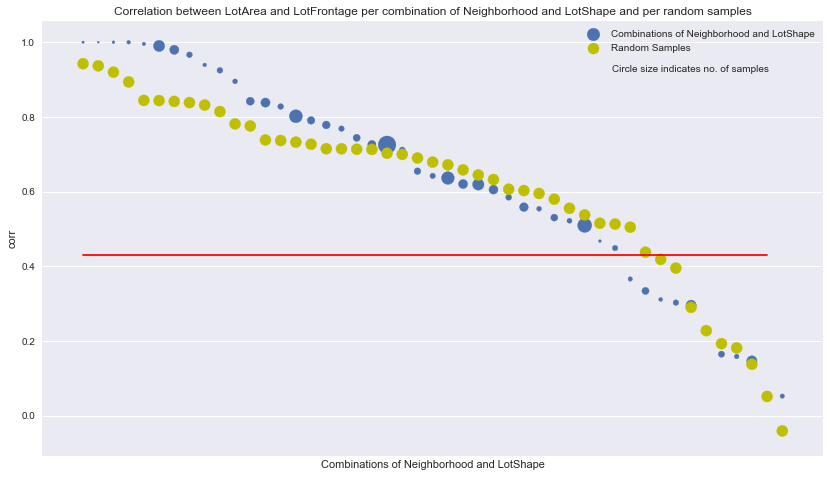

In [42]:
fig = plt.figure(figsize=(14,8))
ax = fig.gca()
lotfrontage_corr_df_sorted.plot.scatter(x="num", y="corr", ax=ax, s=lotfrontage_corr_df_sorted["sample_count"]*2,
                                       label="Combinations of Neighborhood and LotShape")
df_of_random_lotarea_corr_sorted.plot.scatter(x="num", y="corr", ax=ax, s=df_of_random_lotarea_corr_sorted["sample_size"]*4,
                                              color='y', label="Random Samples")
plt.plot([0,45], [0.43, 0.43], "r") # Compare to the general correlation with LotArea
ax.set_title("Correlation between LotArea and LotFrontage per combination of Neighborhood and LotShape and per random samples")
ax.set_xlabel("Combinations of Neighborhood and LotShape")
plt.setp(ax.get_xticklabels(), visible=False) # Taking out the xtickslabels (the description of the combinations)
ax.xaxis.grid(False) # Leaving only the y grid
ax.text(0.73, 0.90, 'Circle size indicates no. of samples', horizontalalignment='left', verticalalignment='top', transform=ax.transAxes)
plt.show()

It seems that combining by Neighborhhod and LotShape does not increase the correlation within groups significantly, compared to random samples as I originally thought. But any way, for most of the data the correlation between LotArea and LotFrontage is **greater than 43%**, as the general correlation. So I need to find the regression line between each combination and use it to fill the missing values. For example:

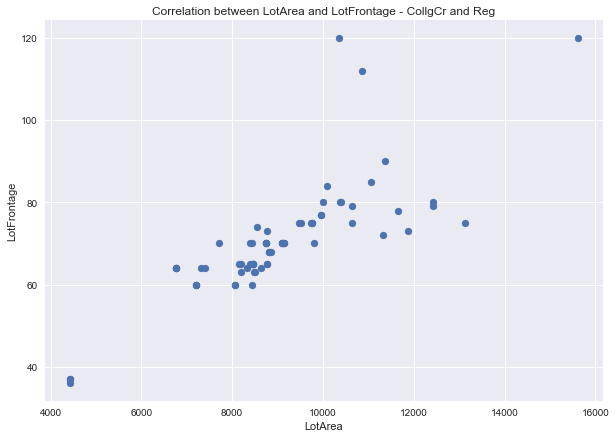

In [43]:
combination_example = train_data[(train_data["Neighborhood"] == "CollgCr") & (train_data["LotShape"] == "Reg")]
fig = plt.figure(figsize=(10, 7))
plt.scatter(combination_example["LotArea"], combination_example["LotFrontage"])
plt.title("Correlation between LotArea and LotFrontage - CollgCr and Reg")
plt.xlabel("LotArea")
plt.ylabel("LotFrontage")
plt.show()

Now add the missing values

In [44]:
# Step 1 is to create a dictionary of the regression lines coefficients per combination of Neighborhood and LotShape, based on 
# train_data.
neighborhoods = train_data["Neighborhood"].unique()
lotshapes = train_data["LotShape"].unique()
# The dictionary is where I store the coefficients - a tuple with the slope and the intercept per combination
# For combinations where there are no values (all are NaNs) or if there is only one value, I cannot have regression line, so
# I store the median of the whole neighborhood instead
support_values_lotfrontage_fillna_dict = {}  
for neighborhood in neighborhoods:
    for lotshape in lotshapes:
        combination = neighborhood + lotshape
        # The following line creates a subset of the train_data slices by the relevant neighborhood and lot shape
        lot_frontage_area_per_combination = train_data[["LotFrontage", "LotArea"]][(train_data["Neighborhood"] == neighborhood) & 
                                                                                   (train_data["LotShape"] == lotshape)]
        # This if statement id for the case where I cannot create a regression line (les than two values)
        if lot_frontage_area_per_combination["LotFrontage"].notnull().sum() < 2:
            # In this case I use the LotFrontage median of the entire neighborhood
            neighborhood_lotfrontage_medians = train_data.groupby("Neighborhood")["LotFrontage"].median()
            median_for_combination = neighborhood_lotfrontage_medians[neighborhood] # Takes the relevant medain fron the groupby
            support_values_lotfrontage_fillna_dict[combination] = median_for_combination # Adds value to the dictionary                                                   
        # Here is where I can generate a regression line
        else: 
            # Droping NaNs to allow the regression line calculation
            lot_frontage_area_per_combination_nonulls = lot_frontage_area_per_combination.dropna()
            slope, intercept, r_value, p_value, std_err = stats.linregress(lot_frontage_area_per_combination_nonulls["LotArea"],
                                                                           lot_frontage_area_per_combination_nonulls['LotFrontage'])
            support_values_lotfrontage_fillna_dict[combination] = (slope, intercept) # Adds tuple to the dictionary 

C:\Users\ishay\Anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:106: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm


In [45]:
# Step 2 is to fill the NaNs, using the following function
def fillna_lotfrontage(df, support_dict = support_values_lotfrontage_fillna_dict):
    """ Fill missing values for LotFrontage"""
    
    neighborhoods = df["Neighborhood"].unique()
    lotshapes = df["LotShape"].unique()
    for neighborhood in neighborhoods:
        for lotshape in lotshapes:
            combination = neighborhood + lotshape
            # The following line creates a subset of the train_data slices by the relevant neighborhood and lot shape
            lot_frontage_area_per_combination = df[["LotFrontage", "LotArea"]][(df["Neighborhood"] == neighborhood) & 
                                                                                   (df["LotShape"] == lotshape)]
            # The following if statement differentiate between a situation where tuple is in the dictionary (then I can 
            # generate a regression line with the slope and intercept) and where there is only a value
            if type(support_dict[combination]) != tuple:
                lot_frontage_area_per_combination["LotFrontage"] = lot_frontage_area_per_combination["LotFrontage"].\
                                                                fillna(support_dict[combination])
            else:
                slope, intercept = support_dict[combination]
                lot_frontage_area_per_combination["LotFrontage"] = lot_frontage_area_per_combination["LotFrontage"].\
                                                                fillna(lot_frontage_area_per_combination["LotArea"] * slope + intercept)
            # The following 4 lines actually fill the NaNs
            slice_condition1 = df["Neighborhood"] == neighborhood
            slice_condition2 = df["LotShape"] == lotshape
            idx = df[slice_condition1 & slice_condition2].index # I need the index of the rows to be filled
            df.loc[idx, ["LotFrontage", "LotArea"]] = lot_frontage_area_per_combination # Using the updated subset
    return df

In [46]:
fillna_lotfrontage_transformer = FunctionTransformer(func=fillna_lotfrontage, validate=False, accept_sparse=False)

 **Alley** (1367 missing values)

The description file says: NA No alley access, so this is what I am filling in

In [47]:
def fillna_alley(df):
    """ Fill missing values for Alley"""
    
    df["Alley"].fillna(value="No alley access", inplace=True)
    return df

In [48]:
fillna_alley_transformer = FunctionTransformer(func=fillna_alley, validate=False)

**MasVnrType and MasVnrArea** (8 missing values)

In [49]:
train_data["MasVnrType"].value_counts()

None       864
BrkFace    445
Stone      126
BrkCmn      15
Name: MasVnrType, dtype: int64

I see that there is already value "None", so I cannot assume that NaNs are no veneer. However, I see that most houses do not have verneer ("None"), so I am going to fill MasVnrType with None and MasVnrArea with 0

In [50]:
def fillna_masvnr(df):
    """ Fill missing values for MasVnrType and for MasVnrArea"""
    
    df["MasVnrType"].fillna(value="None", inplace=True)
    df["MasVnrArea"].fillna(value=0, inplace=True)
    return df

In [51]:
fillna_masvnr_transformer = FunctionTransformer(func=fillna_masvnr, validate=False)

**Basement Features** (37/38 missing values)

for all the basement columns (object ones), NA means No Basement. But I see that some of the features have 37 and some have 38 (BsmtExposure and BsmtFinType2). So first I will check what is this difference, by looking for the rows with nulls in these two features, and with no nulls in the other basement features:

In [52]:
cond1 = train_data["BsmtExposure"].isnull()
cond2 = train_data["BsmtFinType2"].isnull()
cond3 = train_data["BsmtQual"].notnull() # BsmtCond represents the other basement features with 37 nulls
bsmt_null_difference = train_data[(cond1 | cond2) & cond3]
bsmt_null_difference

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
332,333,20,RL,85.0,10655,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,10,2009,WD,Normal,284000
948,949,60,RL,65.0,14006,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Normal,192500


In [53]:
# But I want to see only the relevant features, so:
# The next code lines find the column index of the features of the first and last basement features
first_bsmt = train_data.columns.get_loc("BsmtQual") # The first
last_bsmt = train_data.columns.get_loc("BsmtUnfSF") # The last
# The following line gives me the basement features values for these rows
bsmt_null_difference.iloc[0:2, first_bsmt:last_bsmt+1]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF
332,Gd,TA,No,GLQ,1124,NaN,479,1603
948,Gd,TA,NaN,Unf,0,Unf,0,936


In row 948 I have Nan only in the BsmtExposure feature, and in 332 I have in BsmtFinType2. According to the documentation NA means no basement, but thesehouses have basement. I will check the value counts to see what to fill in.

In [54]:
# I am looking at the values of each of these columns to identify if there is a value that is most common
features_for_value_counts = ["BsmtExposure", "BsmtFinType2"]
for feature in features_for_value_counts:
    print(train_data[feature].value_counts())

No    953
Av    221
Gd    132
Mn    114
Name: BsmtExposure, dtype: int64
Unf    1254
Rec      54
LwQ      46
BLQ      33
ALQ      19
GLQ      14
Name: BsmtFinType2, dtype: int64


I see that "No" is most prevalent for BsmtExposure, and "Unf" is the most prevalent for BsmtFinType2

To generalize it, where I have a value in **BsmtQual** (means that **there is** a basement), I fill it with the mode of the specific column of the NaN. Where I have NaN in BsmtQual, I fill all the NaNs in the row with "No Basement" 

In [55]:
basement_features_to_examine = ["BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinSF1", "BsmtFinType2", "BsmtFinSF2",\
                       "BsmtUnfSF"]

In [56]:
def fillna_basement(df, basement_features = basement_features_to_examine):
    """ Fill missing values in all basement features"""
    
    # The following for loop takes care of the situation where there is no basement (NaN in BsmtQual)
    for i in range(len(df)):
        if pd.isnull(df.iloc[i, df.columns.get_loc("BsmtQual")]):
            for column in basement_features:
                df.iloc[i, df.columns.get_loc(column)] = "No Basement"
    # At this point all the NaN that are left are where there is a basement, but some values are missing
    for column in basement_features:
        df[column] = df[column].fillna(df[column].mode()[0]) # filling in the column's mode
    return df

In [57]:
fillna_basement_transformer = FunctionTransformer(func = fillna_basement, validate=False)

**Electrical** (1 missing value)

I have only one null. I will check the value_count to see if there is a dominant value

In [58]:
train_data["Electrical"].value_counts()

SBrkr    1332
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

I see that more than 90% of the values in this feature are SBrkr, so this is what I use to fill in.

In [59]:
def fillna_electrical(df):
    """ Fill missing values in Electrical"""
    
    df["Electrical"].fillna(value="SBrkr", inplace=True)
    return df

In [60]:
fillna_electrical_transformer = FunctionTransformer(func = fillna_electrical, validate=False)

**FireplaceQu** (690 missing values)

The description says that NA means No Fireplace. I am examining if NA matches the 0 fireplaces in the Fireplaces feature.

In [61]:
train_data[(train_data["Fireplaces"] != 0) & (train_data["FireplaceQu"].isnull())]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


I see that they match (all the 0 in the Fireplaces are the NaNs in the FireplaceQu). So the FireplaceQu is redundant.

In [62]:
def drop_fireplacequ(df):
    """ Drop the FireplaceQu feature"""
    
    df.drop("FireplaceQu", axis=1, inplace=True)
    return df

In [63]:
drop_fireplacequ_transformer = FunctionTransformer(func = drop_fireplacequ, validate = False)

**Garage features** (81 missing values, except for two features that indicate the area and no. of cars)

Null means No garage.

In [64]:
garage_feature_nulls = ["GarageType", "GarageYrBlt", "GarageFinish", "GarageQual", "GarageCond"]

In [65]:
def fillna_garage(df, garage_features = garage_feature_nulls):
    """ Fill missing values in the Garage features"""
    
    for feature in garage_features:
        df[feature].fillna(value="No Garage", inplace=True)
    return df

In [66]:
fillna_garage_transformer = FunctionTransformer(func = fillna_garage, validate=False)

**PoolQC** (1084 missing values)

I want to see if the nulls match the zero value in the PoolArea feature, if the houses with no NaNs are the same houses with numeric value for PoolArea.

In [67]:
print(train_data["PoolArea"].value_counts())
print(train_data[train_data["PoolArea"] != 0][["PoolArea", "PoolQC"]])

0      1452
738       1
648       1
576       1
555       1
519       1
512       1
Name: PoolArea, dtype: int64
      PoolArea PoolQC
197        512     Ex
810        648     Fa
1170       576     Gd
1182       555     Ex
1386       519     Fa
1423       738     Gd


I see that they match (same houses with PoolArea greater than 0 and with PoolQC data), it means that the PoolQC feature is redundant and I can take it off

In [68]:
def drop_poolqc(df):
    """ Drop the PoolQc feature"""
    
    df.drop("PoolQC", axis=1, inplace=True)
    return df

In [69]:
drop_poolqc_transformer = FunctionTransformer(func = drop_poolqc, validate = False)

**Fence** (1177 missing values)

According to the description file NA means No Fence

In [70]:
def fillna_fence(df):
    """ Fill missing values in Fence"""
    
    df["Fence"].fillna("No Fence", inplace=True)
    return df    

In [71]:
fillna_fence_transformer = FunctionTransformer(func = fillna_fence, validate=False)

**MiscFeature** (1404 missinf values)

According to the description file NA means None

In [72]:
def fillna_miscfeature(df):
    """ Fill missing values in MiscFeature"""
    
    df["MiscFeature"].fillna("None", inplace=True)
    return df

In [73]:
fillna_miscfeature_transformer = FunctionTransformer(func = fillna_miscfeature, validate=False)

In [74]:
# Creating a pipeline object for the missing values transformers so far
missing_values_pipeline = Pipeline([('fillna_lotfrontage', fillna_lotfrontage_transformer),
                                    ('fillna_alley', fillna_alley_transformer),
                                    ('fillna_masvnr', fillna_masvnr_transformer),
                                    ('fillna_basement', fillna_basement_transformer),
                                    ('fillna_electrical', fillna_electrical_transformer),
                                    ('drop_fireplacequ', drop_fireplacequ_transformer),
                                    ('fillna_garage', fillna_garage_transformer),
                                    ('drop_poolqc', drop_poolqc_transformer),
                                    ('fillna_fence', fillna_fence_transformer),
                                    ('fillna_miscfeature', fillna_miscfeature_transformer)]) #('drop_poolqc', drop_poolqc_transformer),

In [75]:
# Transforming the datasets 
dfs = [train_data, test_data]
for i, item in enumerate(dfs):
    dfs[i] = missing_values_pipeline.transform(dfs[i])
train_data, test_data = dfs

In [76]:
# Making sure that I don't have missing values left
dfs = [train_data, test_data]
names = ["train_data", "dev_data", "test_data"]
for i in range(2):
    print("Missing values in {}: ".format(names[i]), dfs[i].isnull().sum().sum())

Missing values in train_data:  0
Missing values in dev_data:  19


I have missing values in test_data, because it has additional values were not seen before (I filled in the features that had null only in train_data).

In [77]:
# Check how many nulls in test_data 
for feature in test_data:
    if test_data[feature].isnull().sum() != 0:
        print("{:20} {}".format(feature, test_data[feature].isnull().sum()))

MSZoning             4
Utilities            2
Exterior1st          1
Exterior2nd          1
TotalBsmtSF          1
BsmtFullBath         2
BsmtHalfBath         2
KitchenQual          1
Functional           2
GarageCars           1
GarageArea           1
SaleType             1


All the following checks will be done of the training set, even though I am filling the test set, to aviod overfitting.

**MSZoning** (4 missing values in test_data)

By reading the data description, it looks as if this feature might be connected to the neighborhood. I will examine it.

Text(0.5,1,'Pairwise Association Bewtween MSZoning and Neighborhood')

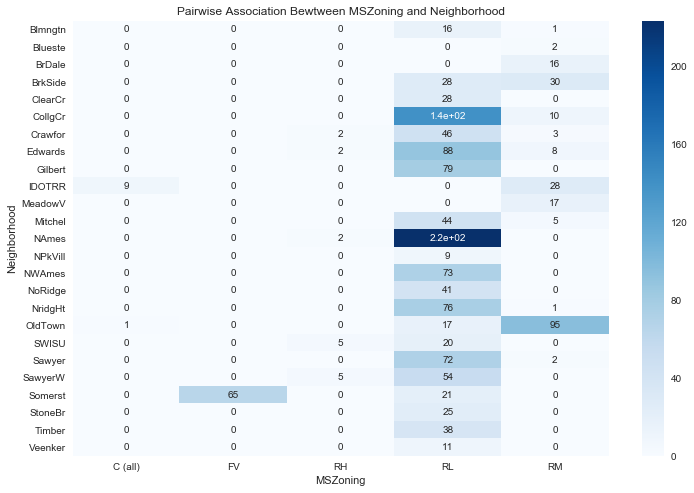

In [78]:
# This cross tab creates pairwise association between MSZoning and Neighborhood, to see the prevalent category in every 
# neighborhood
cross_tab_msz = pd.crosstab(train_data["Neighborhood"], train_data["MSZoning"])
f, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(cross_tab_msz, cmap="Blues", annot=True)
ax.set_title('Pairwise Association Bewtween MSZoning and Neighborhood')

In [79]:
# Now checking which neighborhood they are in
test_data["Neighborhood"][test_data["MSZoning"].isnull()]

455      IDOTRR
756      IDOTRR
790      IDOTRR
1444    Mitchel
Name: Neighborhood, dtype: object

IDOTRR - 80% are RM.

Mitchel - 88% are RL.

So I will fill the values by the most common MSZoning per neighborhood.

In [80]:
# Examining the neighborhoods of the specific rows witn NaNs
test_data[test_data["MSZoning"].isnull()]["Neighborhood"]

455      IDOTRR
756      IDOTRR
790      IDOTRR
1444    Mitchel
Name: Neighborhood, dtype: object

In [81]:
neighborhood_mszoning_dict = {"IDOTRR": "RM", "Mitchel": "RL"}

In [82]:
test_data["MSZoning"] = test_data["MSZoning"].fillna(test_data["Neighborhood"].map(neighborhood_mszoning_dict))

**Utilities** (2 missing values in test_data)

In [83]:
test_data["Utilities"].value_counts()

AllPub    1457
Name: Utilities, dtype: int64

All rows has the same value. I will use it to fill missing values but will drop this feature later because it has no meaning.

In [84]:
test_data.loc[:,"Utilities"] = test_data["Utilities"].fillna("AllPub")

**Exterior1st and Exterior2nd** (1 missing value per each)

First I will check if the missing values are in the same row.

In [85]:
test_data[(test_data["Exterior1st"].isnull()) & (test_data["Exterior2nd"].isnull())][["Exterior2nd", "Exterior1st"]]

,Exterior2nd,Exterior1st
691,NaN,NaN


In [86]:
# Again I am checking the trianing data
train_data["Exterior1st"].value_counts()

VinylSd    515
HdBoard    222
MetalSd    220
Wd Sdng    206
Plywood    108
CemntBd     60
BrkFace     50
WdShing     26
Stucco      24
AsbShng     20
Stone        2
BrkComm      2
CBlock       1
AsphShn      1
ImStucc      1
Name: Exterior1st, dtype: int64

There is no main value, so I will look for clues in other features

In [87]:
# For each one of the folloing features I am grouping by category to see the prevalence of each Exterior category 
features_to_check_with_ext = ["MSSubClass", "Foundation", "Neighborhood"]

In [88]:
# Now examine the house propoerty to identify the likelihood of each exterior
test_data[(test_data["Exterior1st"].isnull()) & (test_data["Exterior2nd"].isnull())][features_to_check_with_ext]

,MSSubClass,Foundation,Neighborhood
691,30,PConc,Edwards


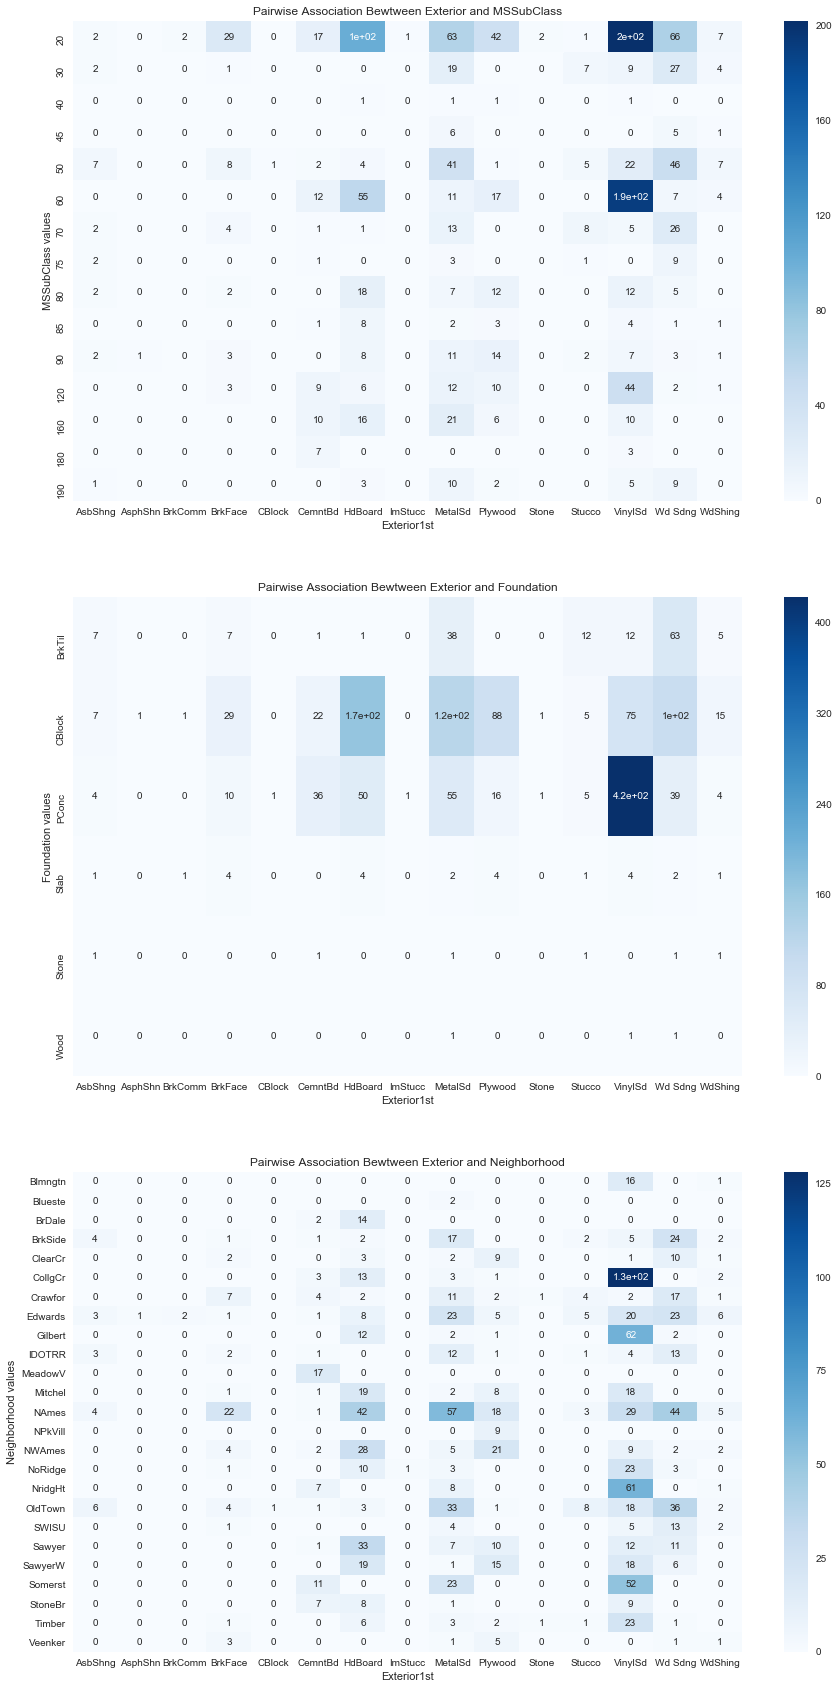

In [89]:
# Now ploting the heatmap and look for the house property
axes = (ax1, ax2, ax3, ax4)
f, axes = plt.subplots(len(features_to_check_with_ext), 1, sharex=True, figsize=(15,30))
for i in range(len(features_to_check_with_ext)):
    cross_tab_ext1 = pd.crosstab(train_data[features_to_check_with_ext[i]], train_data["Exterior1st"])
    ext_heatmap = sns.heatmap(cross_tab_ext1,cmap="Blues",ax=axes[i], annot=True)
    ext_heatmap.set_ylabel(features_to_check_with_ext[i]+ " values")
    ext_heatmap.set_title('Pairwise Association Bewtween Exterior and {}'.format(features_to_check_with_ext[i]))

Based on these three features and the propoerties of the house, I can say that it is most likely that Exterior1st (The second is the same for most houses) is eaither **VinylSD, MetalSD** or **Wd Sdng**. I will go for the VinylSD.

In [90]:
test_data.iloc[691, test_data.columns.get_loc("Exterior1st"):test_data.columns.get_loc("Exterior2nd")+1] = "VinylSD"

In [91]:
test_data.iloc[691, test_data.columns.get_loc("Exterior1st"):test_data.columns.get_loc("Exterior2nd")+1]

Exterior1st    VinylSD
Exterior2nd    VinylSD
Name: 691, dtype: object

### That was a major **overkill** over this single row missing value! It was a good practice though... :-)

**TotalBsmtSF** (1 missing value in test_data)

In [92]:
test_data[test_data["TotalBsmtSF"].isnull()][basement_features_to_examine] 

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF
660,No Basement,No Basement,No Basement,No Basement,No Basement,No Basement,No Basement,No Basement


In [93]:
# This house has no basement, so I need to fill it with 0
test_data.iloc[660, test_data.columns.get_loc("TotalBsmtSF")] = 0

**BsmtFullBath and BsmtHalfBath** (2 missing value each in test_data)

Let's see if they have basement.

In [94]:
test_data[(test_data["BsmtFullBath"].isnull()) | (test_data["BsmtFullBath"].isnull())][["BsmtFullBath", 
                                                                                        "BsmtHalfBath","TotalBsmtSF"]]

,BsmtFullBath,BsmtHalfBath,TotalBsmtSF
660,NaN,NaN,0.0
728,NaN,NaN,0.0


No basement, so these should be 0 as well.

In [95]:
test_data.iloc[[660,728], [test_data.columns.get_loc("BsmtFullBath"), test_data.columns.get_loc("BsmtHalfBath")]] = 0

**KitchenQual** (1 missing value in test_data)

For this one I will just use the mode.

In [96]:
test_data[test_data["KitchenQual"].isnull()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
95,1556,50,RL,72.0,10632,Pave,No alley access,IR1,Lvl,AllPub,...,0,0,0,No Fence,None,0,1,2010,COD,Normal


In [97]:
# Again using the train data figures to get the mode
test_data.iloc[95, test_data.columns.get_loc("KitchenQual")] = train_data["KitchenQual"].mode().values[0]

**Functional** (2 missing values in test_data)

Lets see the value counts

In [98]:
train_data["Functional"].value_counts()

Typ     1358
Min2      34
Min1      31
Mod       15
Maj1      14
Maj2       5
Sev        1
Name: Functional, dtype: int64

The majority is 'Typ' functionality.

In [99]:
# Now I need the index of these rows
test_data[test_data["Functional"].isnull()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
756,2217,20,RM,80.0,14584,Pave,No alley access,Reg,Low,AllPub,...,0,0,0,No Fence,None,0,2,2008,WD,Abnorml
1013,2474,50,RM,60.0,10320,Pave,Grvl,Reg,Lvl,AllPub,...,0,84,0,No Fence,None,0,9,2007,COD,Abnorml


In [100]:
test_data.iloc[[756, 1013], test_data.columns.get_loc("Functional")] = 'Typ'

**GarageArea and GarageCars** (1 missing value each in test_data)

In [101]:
garage_features = ["GarageType", "GarageYrBlt", "GarageFinish", "GarageCars", "GarageArea", "GarageQual", "GarageCond"]
# I want to see these features to see if there is a gerage, also to see if the missing values is in the same row for both 
# GarageArea and GarageCars
test_data[(test_data["GarageArea"].isnull()) | (test_data["GarageCars"].isnull())][garage_features]

,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond
1116,Detchd,No Garage,No Garage,NaN,NaN,No Garage,No Garage


No garage.

In [102]:
test_data.iloc[1116, [test_data.columns.get_loc("GarageArea"), test_data.columns.get_loc("GarageCars")]] = 0

**SaleType** (1 missing value in test_data)

In [103]:
train_data["SaleType"].value_counts()

WD       1267
New       120
COD        43
ConLD       9
ConLw       5
ConLI       5
CWD         4
Oth         3
Con         2
Name: SaleType, dtype: int64

86% are from WD. However the second category, "new", which is substantail, bay be associated with the neighborhood, so it worth making an additioal examination.

In [104]:
# I want to finf the neighborhood of this house
test_data[test_data["SaleType"].isnull()]["Neighborhood"]

1029    Sawyer
Name: Neighborhood, dtype: object

In [105]:
# Checking the train data to find prevalent value
cross_tab_sale_type = pd.crosstab(train_data["Neighborhood"], train_data["SaleType"])
cross_tab_sale_type.loc["Sawyer", :]

SaleType
COD       0
CWD       0
Con       0
ConLD     0
ConLI     1
ConLw     0
New       0
Oth       0
WD       73
Name: Sawyer, dtype: int64

In this neighborhood the probability for "WD" is much higher than 86% so this is what I fill in.

In [106]:
test_data.iloc[1029, test_data.columns.get_loc("SaleType")] = "WD"

In [107]:
# Making sure that test_data is free of nulls
test_data.isnull().sum().sum()

0

No Missing Values!

In [108]:
train_data.shape

(1458, 79)

In [109]:
test_data.shape

(1459, 78)

<a id='Feature Engineering'></a>
## Feature Engineering
[Back to top](#content)

**Condition1 and Condition2**

These two features indicate the proximity of the house to any of the condotions in these columns. If the house has only one, it is mentioned in Condition1. If it has two, the second appears in Condition2. So I want to create a feature with the number of conditions (0/1/2) 

In [110]:
# First I make a list of the unique values in both columns:
condition_set = set(np.concatenate([train_data["Condition1"].unique(), train_data["Condition2"].unique()]))
condition_set

{'Artery', 'Feedr', 'Norm', 'PosA', 'PosN', 'RRAe', 'RRAn', 'RRNe', 'RRNn'}

In [111]:
# Then I make a function that assigns 1 or zero for each item in the set,and sums it
def total_condition(df_row):
    """ 
    The function receives an iterable object, and counts the non-"Norm" values
    input: df_row - an iterable object
    returns the number of items in df_row that are not "Norm"
    """
    sum_of_condition = 0
    for i in range(len(df_row)):
        # For all values that are not "Norm", add 1 to sum_of_conditions
        if df_row[i] != "Norm":
            sum_of_condition += 1
    return sum_of_condition

In [112]:
def add_totalconditions(df):
    """ Add new feature TotalConditions"""
    
    df["TotalConditions"] = df[["Condition1", "Condition2"]].apply(total_condition, axis=1)
    return df

In [113]:
add_totalconditions_transformer = FunctionTransformer(func = add_totalconditions, validate = False)

I am now creating a new data called **valid_data** to run all the examinations during this step, since I want to keep train_data untouched till the transformation with test_data.

In [114]:
valid_data = train_data.copy()

In [115]:
# Checking that it works
valid_data = add_totalconditions_transformer.transform(valid_data)
valid_data[["Condition1", "Condition2", "TotalConditions"]].head(10)

,Condition1,Condition2,TotalConditions
0,Norm,Norm,0
1,Feedr,Norm,1
2,Norm,Norm,0
3,Norm,Norm,0
4,Norm,Norm,0
5,Norm,Norm,0
6,Norm,Norm,0
7,PosN,Norm,1
8,Artery,Norm,1
9,Artery,Artery,2


In [116]:
valid_data.groupby("TotalConditions").agg({'SalePrice' : ['count','mean']})

SalePrice               
                    count           mean
TotalConditions                         
0                    1260  184495.492063
1                     184  158507.994565
2                      14  155028.928571

In [117]:
valid_data.shape

(1458, 80)

It seems that TotalConditions=2 had too few samples. I will change the function so that it returns 1 for any condition and 0 for none (Norm in both features).

In [118]:
def is_conditions(df_row):
    """ 
    The function receives an iterable object, and counts the non-"Norm" values
    input: df_row - an iterable object
    returns the number of items in df_row that are not "Norm"
    """
    sum_of_condition = 0
    for i in range(len(df_row)):
        if df_row[i] != "Norm":
            sum_of_condition += 1
    # At this point the output is like in total_condition function 
    if sum_of_condition == 0 or sum_of_condition == 1:
        return sum_of_condition
    else:
        return 1

In [119]:
def add_isconditions(df):
    """ Add new featureIslConditions"""
    
    df["IsConditions"] = df[["Condition1", "Condition2"]].apply(is_conditions, axis=1)
    return df

In [120]:
add_isconditions_transformer = FunctionTransformer(func = add_isconditions, validate = False)

In [121]:
valid_data = add_isconditions_transformer.transform(valid_data)

In [122]:
valid_data.groupby("IsConditions").agg({'SalePrice' : ['count','median']})

SalePrice        
                 count  median
IsConditions                  
0                 1260  166500
1                  198  144000

In [123]:
train_data.shape

(1458, 79)

In [124]:
test_data.shape

(1459, 78)

**Exterior1st and Exterior2nd**

First I will take a look at some values of this features 

In [125]:
train_data[["Exterior1st", "Exterior2nd"]].head(10)

,Exterior1st,Exterior2nd
0,VinylSd,VinylSd
1,MetalSd,MetalSd
2,VinylSd,VinylSd
3,Wd Sdng,Wd Shng
4,VinylSd,VinylSd
5,VinylSd,VinylSd
6,VinylSd,VinylSd
7,HdBoard,HdBoard
8,BrkFace,Wd Shng
9,MetalSd,MetalSd


It seems as if they look alike. I will examine in how many rows they are the same. 

In [126]:
# Counts the number of rows where thae values are the same in both columns
exterior_is_equal = len(train_data[train_data["Exterior1st"] == train_data["Exterior2nd"]])
# Calculates the percentage of these rows ou of the total
exterior_is_equal_percent = (exterior_is_equal / train_data.shape[0]) * 100
exterior_message = "The values of Exterior1st and Exterior2nd are the same in {} rows, {:.2f}% of the total rows"
print(exterior_message.format(exterior_is_equal, exterior_is_equal_percent))

The values of Exterior1st and Exterior2nd are the same in 1244 rows, 85.32% of the total rows


The features are highly correlated (85% the same), so I will take one out.

In [127]:
def drop_exterior2nd(df):
    """ Drop the Exterior2nd feature"""
    
    df = df.drop("Exterior2nd", axis=1)
    return df

In [128]:
drop_exterior2nd_transformer = FunctionTransformer(func = drop_exterior2nd, validate=False)

In [129]:
valid_data = drop_exterior2nd_transformer.transform(valid_data)

**House Area**

I will combine the basement area and the above ground area into one area called HouseArea. I will not combine the garage area, since it is not necessarily a part of the house, as indicated in the description file.

In [130]:
def add_house_area(df):
    """ Add HouseArea feature"""
    
    df["HouseArea"] = df["GrLivArea"] + df["TotalBsmtSF"]
    return df

In [131]:
add_house_area_transformer = FunctionTransformer(func = add_house_area, validate=False)

In [132]:
valid_data = add_house_area_transformer.transform(valid_data)

**Bathrooms**

I would like to combine the number of bathrooms, there are currently four distinct features for them.

In [133]:
def add_total_bath(df):
    """ Add TotalBath feature"""
    
    # For the half bath features I am taking only half (dividing by 2)
    df["TotalBath"] = df["BsmtFullBath"] + df["FullBath"] + (df["BsmtHalfBath"] + df["HalfBath"])/2
    return df

In [134]:
add_total_bath_transformer = FunctionTransformer(func = add_total_bath, validate=False)

In [135]:
# Making sure that it is working
valid_data = add_total_bath_transformer.transform(valid_data)
valid_data[["BsmtFullBath", "BsmtHalfBath", "FullBath", "HalfBath", "TotalBath"]].head()

,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,TotalBath
0,1,0,2,1,3.5
1,0,1,2,0,2.5
2,1,0,2,1,3.5
3,1,0,1,0,2.0
4,1,0,2,1,3.5


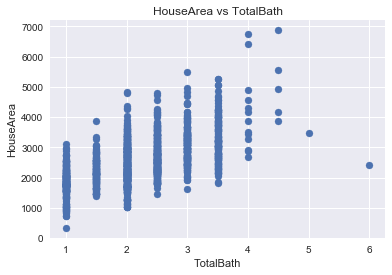

In [136]:
# I am making sure that TotalBath is not too correlated with the HouseArea (so it is not redundant)
plt.scatter(valid_data["TotalBath"], valid_data["HouseArea"])
plt.xlabel("TotalBath")
plt.ylabel("HouseArea")
plt.title("HouseArea vs TotalBath")
plt.show()

**Porch**

There are four types of porch features (indicating area), and I will sum them into one featue TotalPorch

In [137]:
def add_total_porch(df):
    """ Add TotalPorch feature"""
    
    df["TotalPorch"] = df.loc[:, ["OpenPorchSF", "EnclosedPorch", "3SsnPorch", "ScreenPorch"]].sum(axis=1)
    return df

In [138]:
add_total_porch_transformer = FunctionTransformer(func = add_total_porch, validate=False)

In [139]:
# Making sure that it is working
valid_data = add_total_porch_transformer.transform(valid_data)
valid_data[["OpenPorchSF", "EnclosedPorch", "3SsnPorch", "ScreenPorch", "TotalPorch"]].head(10)

,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,TotalPorch
0,61,0,0,0,61
1,0,0,0,0,0
2,42,0,0,0,42
3,35,272,0,0,307
4,84,0,0,0,84
5,30,0,320,0,350
6,57,0,0,0,57
7,204,228,0,0,432
8,0,205,0,0,205
9,4,0,0,0,4


**YearBuilt**

This feature was in my top 15 important features and I want to make the best of it.
1. I will calculate the age of the house upon sale
2. Explore the interaction with YearRemodAdd
3. I will add an external price index 

1. Calculating the age of the house upon sale

In [140]:
def add_house_age(df):
    """ Add HouseAge feature"""
    
    df["HouseAge"] = df["YrSold"] - df["YearBuilt"]
    return df

In [141]:
add_house_age_transformer = FunctionTransformer(func = add_house_age, validate=False)

In [142]:
valid_data = add_house_age_transformer.transform(valid_data)

I am examining the HouseAge vs SalePrice

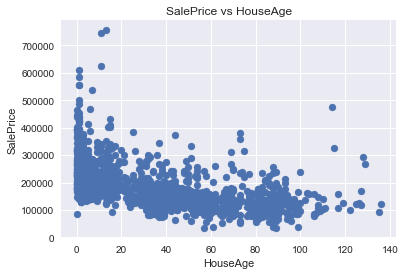

In [143]:
plt.scatter(valid_data["HouseAge"], valid_data["SalePrice"])
plt.xlabel("HouseAge")
plt.ylabel("SalePrice")
plt.title("SalePrice vs HouseAge")
plt.show()

It looks as if the prices go up for houses with age less than 20 years. I will examine it a bit further

In [144]:
# Finds the median price per age
grpby_age = valid_data.groupby("HouseAge")["SalePrice"].median()

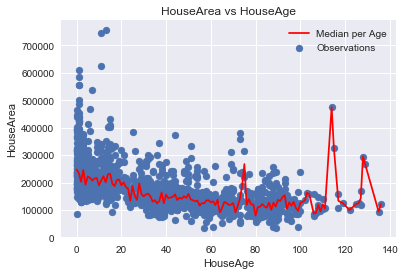

In [145]:
plt.scatter(valid_data["HouseAge"], valid_data["SalePrice"], label="Observations")
plt.plot(grpby_age, 'r', label="Median per Age")
plt.xlabel("HouseAge")
plt.ylabel("HouseArea")
plt.title("HouseArea vs HouseAge")
plt.legend()
plt.show()

There is a clear trend but some variability that I want to avoid, especially in the old houses. So I will find the medain per range of ages, and use it as a reference for the age (0-10, 10-20, and so on)

In [146]:
def add_house_age_range(df):
    """ Add HouseAgeRange feature"""
    
    df["HouseAgeRange"] = (df["HouseAge"] // 10) * 10
    return df

In [147]:
add_house_age_range_transformer = FunctionTransformer(func = add_house_age_range, validate=False)

In [148]:
valid_data = add_house_age_range_transformer.transform(valid_data)

In [149]:
# Then I find the median per segment for visualization
grpby_house_age_range = valid_data.groupby("HouseAgeRange")["SalePrice"].median()
grpby_house_age_range

HouseAgeRange
0      222000
10     204750
20     175250
30     145000
40     144000
50     135000
60     123550
70     129900
80     115000
90     128000
100    122250
110    132450
120    124000
130    108000
Name: SalePrice, dtype: int64

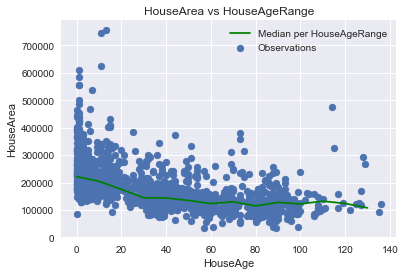

In [150]:
# Scatter is the age per observation
plt.scatter(valid_data["HouseAge"], valid_data["SalePrice"], label="Observations")
# The plot is the median price per range of age
plt.plot(grpby_house_age_range.index, grpby_house_age_range.values, 'g', label="Median per HouseAgeRange")
plt.xlabel("HouseAge")
plt.ylabel("HouseArea")
plt.title("HouseArea vs HouseAgeRange")
plt.legend()
plt.show()

Bottom line - I will use the HouseAgeRange feature

**Explore the interaction with YearRemodAdd**

This feature is tricky, because it equals the **YearBuilt** feature if there was no remodeling. Also it makes sense that remodeling that took place many years before the sale will have less impact. I will explore the connection between these two features and the impact on the **SalePrice**

In [151]:
# First I create a feature with the age of the remodeling
def add_remod_age(df):
    """ Add RemodAge feature"""
    
    df["RemodAge"] = df["YrSold"] - df["YearRemodAdd"]
    return df

In [152]:
add_remod_age_transformer = FunctionTransformer(func = add_remod_age, validate=False)

In [153]:
valid_data = add_remod_age_transformer.transform(valid_data)

I want to know if the timing of the remodeling makes any difference for the price.

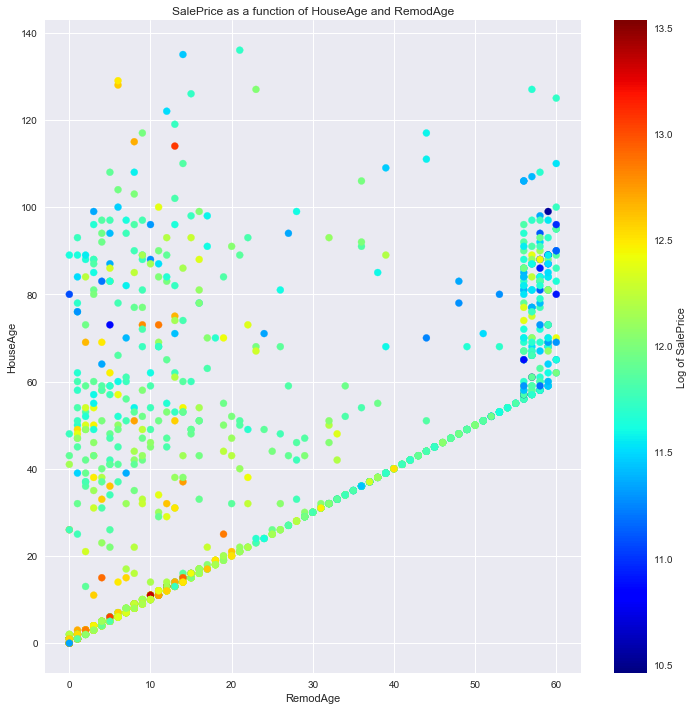

In [154]:
#I am using log for the price, because I tried to do it without the log and almost all points were blue
fig, ax = plt.subplots(figsize=(12,12))
scat = plt.scatter(valid_data["RemodAge"], valid_data["HouseAge"], c=np.log(valid_data["SalePrice"]), cmap='jet')
cb = plt.colorbar(scat, spacing='proportional')
cb.set_label('Log of SalePrice')
plt.xlabel("RemodAge")
plt.ylabel("HouseAge")
plt.title("SalePrice as a function of HouseAge and RemodAge")

plt.show()

First some explanation: High point represent old houses, low points represent new houses. Point on the left hand side represent houses that were remoodeled lately and on the right hand side are houses that were remodeled in the past.

Some insights:
1. My hypotheses, that a new remodeling will make SalePrice higher than older remodeling (for the same level of HouseAge), is not true according to the chart. If it was true, I would see a clear change in color from blue to green or from green to yellow, as I move to the left. Also, if it was true, I would factorise the age of the remodeling.
2. The linear line represents the houses with no remodeling (HouseAge = RemodAge). On the right hand side of this line (between 56-60) we see suddenly many houses above the line something that doesn't seem real. Because the linear line is cut in 60, the data assumes that there are no houses older than 60 that were not remodeled. My assumption is that most of these houses were not remodeled, so I will create a new feature RealRemodAge.

In [155]:
def real_remodeling(row_df):
    """ Assigns the building year if the remodeling is higher than threshold, and the remodeling year if lower"""
    
    threshold = 55
    if row_df[0] >= threshold:
        return row_df[1]
    else:
        return row_df[0]

In [156]:
def add_real_remod_age(df):
    """ Add the RealRemodAge based on the real_remodeling function"""
    
    df["RealRemodAge"] = df[["RemodAge", "HouseAge"]].apply(real_remodeling, axis=1)
    return df

In [157]:
add_real_remod_age_transformer = FunctionTransformer(func = add_real_remod_age, validate=False)

In [158]:
valid_data = add_real_remod_age_transformer.transform(valid_data)

In [159]:
valid_data[["RemodAge", "HouseAge", "RealRemodAge"]].head(10)

,RemodAge,HouseAge,RealRemodAge
0,5,5,5
1,31,31,31
2,6,7,6
3,36,91,36
4,8,8,8
5,14,16,14
6,2,3,2
7,36,36,36
8,58,77,77
9,58,69,69


Now I would like to distinguish between ages of remodeling in order to see the impact of remodeling. I will devide the data into three categories. This is not a feature to be used, but a supoprt column:
1. No Remodeling
2. Old Remodeling, where remodeling took place more than 20 years before sale
3. New Remodeling

In [160]:
# This threshold distinguishes between new and old remodeling. New remodeling is one that took place less than threshold year
# prior to the sale
new_old_threshold_1 = 20 
def modeling_type(row_df):
    """ 
    The function receives an iterable object, and counts the non-"Norm" values
    input: df_row - an iterable object
    returns the number of items in df_row that are not "Norm"
    """
    
    if row_df[0] == row_df[1]: # If the real remodeling age equals to the house age, it is considered as no remodeling
        return "No Remodeling"
    else:
        if row_df[0] >= new_old_threshold_1:
            return "Old Remodeling"
        else:
            return "New Remodeling"

In [161]:
def add_remod_type(df):
    """ Add RemodType as a support feature, based on modeling_type function"""
    
    df["RemodType"] = df[["RealRemodAge", "HouseAge"]].apply(modeling_type, axis=1) 
    return df

In [162]:
add_remod_type_transformer = FunctionTransformer(func = add_remod_type, validate=False)

In [163]:
valid_data = add_remod_type_transformer.transform(valid_data)

In [164]:
# I want to get the medain for each one of the groups. Also the count is to be sure that the conclusion I reach are not based on
# groups with too few samples
grpby_remod_type = valid_data.groupby(["RemodType", "HouseAgeRange"]).agg({"SalePrice": ['median', 'count']})
grpby_remod_type

SalePrice      
                                median count
RemodType      HouseAgeRange                
New Remodeling 0              244600.0   143
               10             208900.0    69
               20             183500.0    14
               30             180500.0    30
               40             151125.0    42
               50             144900.0    45
               60             131500.0    22
               70             134900.0    21
               80             128000.0    37
               90             129000.0    22
               100            145900.0     7
               110            159500.0     5
               120            194989.5     4
               130             94000.0     1
No Remodeling  0              215000.0   267
               10             202000.0    78
               20             172500.0    46
               30             141250.0   162
               40             141000.0   126
               50             128450.0    96
               60             116500.0    42
               70             128000.0    25
               80             108250.0    56
               90             121000.0    23
               100             90000.0     5
               110            102776.0     1
               120            120000.0     2
Old Remodeling 20             165500.0     4
               30             171000.0     7
               40             159000.0    15
               50             140000.0    11
               60             132750.0     6
               70              84500.0     5
               80             109490.0     6
               90             140000.0     7
               100            127500.0     2
               110            106750.0     2
               120            168000.0     1
               130            122000.0     1

I see that from 100 and beyond I have too little observations, so I am excluding this part from the analysis 

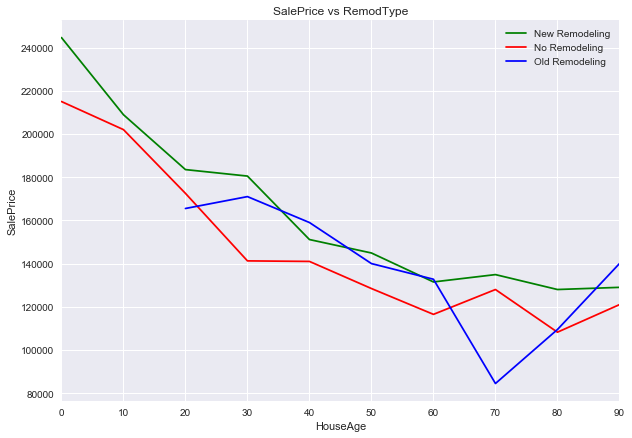

In [165]:
# The purpose of this chart is to examine the impact on SalePrice of the different remodeling types (no remodeling, old
# remodeling, new remodeling)
remodeling_types = ["New Remodeling", "No Remodeling", "Old Remodeling"] # The three types created by RemodType
remodeling_colors = ['g', 'r', 'b'] # Assigning colors
plt.figure(figsize=(10,7))
for i in range(3):
    x = grpby_remod_type["SalePrice"]["median"][remodeling_types[i]].index 
    y = grpby_remod_type["SalePrice"]["median"][remodeling_types[i]].values 
    plt.plot(x, y, remodeling_colors[i], label=remodeling_types[i])
plt.ylabel("SalePrice")
plt.xlabel("HouseAge")
plt.title("SalePrice vs RemodType")
plt.xlim(0,90) # Excluding the data from 100 and beyond because of too few samples
plt.legend()
plt.show()

Conclusion - I see that for most ages, a remodeled house SalePrice is higher than a house with no remodeling (and again, like the previous chart, I don't see a significant difference between an old remodeling (older than 20 years, in blue) and a new one, in green. In this case I will create a binary feature for with/without remodeling.

Note: houses aged 20 with old remodeling have roughly the same SalePrice as houded aged 20 and with No remodeling. This makes sense, because the threshlod for new/old houses is 20 years (they built the house and then remodeled it right away).

In [166]:
def add_is_remod(df):
    """ Add IsRemod feature"""
    
    df["IsRemod"] = np.where(df['RealRemodAge'] == df['HouseAge'], 0, 1)
    return df

In [167]:
add_is_remod_transformer = FunctionTransformer(func = add_is_remod, validate=False)

In [168]:
valid_data = add_is_remod_transformer.transform(valid_data)

Bottom line - I will use the IsRemode to deal with the remodeling issue

**GarageYrBlt**

I want to see if I need this feature. I will examine the connection with the YearBuilt

Text(0.5,1,'YearBulit vs GarageYrBlt')

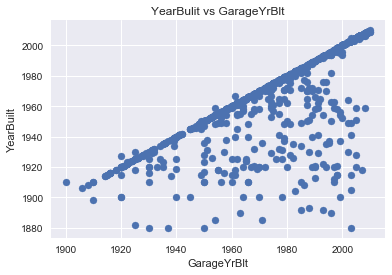

In [169]:
garage_house_years = train_data[["GarageYrBlt", "YearBuilt"]]
garage_house_years = garage_house_years[train_data["GarageYrBlt"] != "No Garage"]
plt.scatter(garage_house_years["GarageYrBlt"], garage_house_years["YearBuilt"])
plt.xlabel("GarageYrBlt")
plt.ylabel("YearBuilt")
plt.title("YearBulit vs GarageYrBlt")

Most of the houses the building year of the garage is the same as the house's. Redundant feature, will be removed later on.

**MasVnrArea and MasVnrType**

This feature was in the top 20 most important features so I am examining it.

Text(0.5,1,'SalePrice vs MasVnrArea')

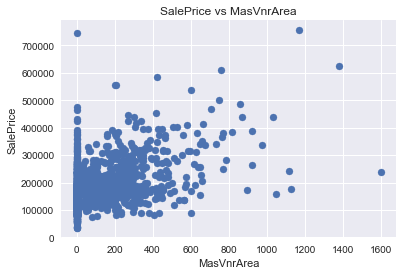

In [170]:
plt.scatter(train_data["MasVnrArea"], train_data["SalePrice"])
plt.ylabel("SalePrice")
plt.xlabel("MasVnrArea")
plt.title("SalePrice vs MasVnrArea")

It looks as if there is some associaiton with the price. But I also see many zeros (No vaneer).

In [171]:
train_data.groupby("MasVnrType").agg({"SalePrice": ['count', 'median']})

SalePrice        
               count  median
MasVnrType                  
BrkCmn            15  139000
BrkFace          445  181000
None             872  143125
Stone            126  248614

I will assign a number 1/2/3 by the impact on SalePrice

In [172]:
vnr_dict = {"BrkCmn": 1, "None": 1, "BrkFace": 2, "Stone": 3}

In [173]:
def add_mas_vnr_type_num(df):
    """ Add MasVnrTypeNum feature based on vnr_dict dictionary"""
    
    df["MasVnrTypeNum"] = df["MasVnrType"].map(vnr_dict)
    return df

In [174]:
add_mas_vnr_type_num_transformer = FunctionTransformer(func = add_mas_vnr_type_num, validate=False)

In [175]:
valid_data = add_mas_vnr_type_num_transformer.transform(valid_data)

In [176]:
# Examining the new feature
valid_data[["MasVnrType", "MasVnrTypeNum"]].head()

,MasVnrType,MasVnrTypeNum
0,BrkFace,2
1,None,1
2,BrkFace,2
3,None,1
4,BrkFace,2


I will use both the area and the numeric version of the type.

**Add the price index**

I believe that price index play a role in the sale prices of this data. Of course I can create the price index from the data but this would be overfitting (I guess..). So I found the [house price index of Iowa](https://fred.stlouisfed.org/series/IASTHPI) and decided to see if I can use it (I found also for Ames specifically, but I believe that would be too specific, I mean it would match the data).

In [177]:
price_index = pd.read_csv(r"C:\Users\ishay\Documents\Data Science\Kaggle\House Prices\Iowa_house_price_index.csv")
price_index = price_index.rename(index=str, columns={price_index.columns[2]: "2006_idx"})
price_index.tail()

,DATE,IASTHPI,2006_idx
23,01-07-09,246.18,1.031466
24,01-10-09,245.59,1.028994
25,01-01-10,243.78,1.021410
26,01-04-10,244.57,1.024720
27,01-07-10,246.76,1.033896


In [178]:
# I am creating a dictionary with the dates and the index
price_idx_dict = {}
for row in price_index.iterrows():
    # The strptime variable is the key in the dictionary
    strptime = datetime.datetime.strptime(row[1][0], "%d-%m-%y")
    # The price index (row[1][2]) is the value in the dictionary
    price_idx_dict[strptime] = row[1][2]

In [179]:
# Now I am creating a new column with the price index
def add_price_index(df):
    """ Add the 2006_idx feature, based on the real price index of Iowa"""
    
    # First calculating the right integer
    df["QuarterStartDate"] = df['YrSold'] * 10000 + df['MoSold'] * 100 + 1
    # Then finding the actual date of the sale
    df["QuarterStartDate"] = pd.to_datetime(df["QuarterStartDate"].apply(str))
    # Then bring the date of the beginning of the quarter, like I have in the price_index data
    df["QuarterStartDate"] = df["QuarterStartDate"] - pd.tseries.offsets.QuarterEnd() + datetime.timedelta(days=1)
    # Then match with the price_idx_dict
    df["2006_idx"] = df["QuarterStartDate"].map(price_idx_dict)
    return df

In [180]:
add_price_index_transformer = FunctionTransformer(func = add_price_index, validate=False)

In [181]:
valid_data = add_price_index_transformer.transform(valid_data)

**MoSold**

Month is actually a categorical feature, so I turn it into a string.

In [182]:
def modify_mosold(df):
    """ Turn MoSold feature into a string"""
    
    df["MoSold"] = df["MoSold"].astype(str)
    return df

In [183]:
modify_mosold_transformer = FunctionTransformer(func = modify_mosold, validate=False)

In [184]:
valid_data = modify_mosold_transformer.transform(valid_data)
# Making sure It worked
valid_data["MoSold"].dtype

dtype('O')

<a id='Modeling'></a>
## Modeling
[Back to top](#content)

My approach is to reach optimization through testing different combinations of the following:
1. Using different methods for sorting features (feature importances, RFE, PCA)
2. Trying different models
3. In each model trying various hyperparameters
4. Running different number of variables to find minimal error (sweet point)
5. Changing some of the features in scope

I made this **modeling process map** to further explain the steps I am taking and to guide the reader through them:

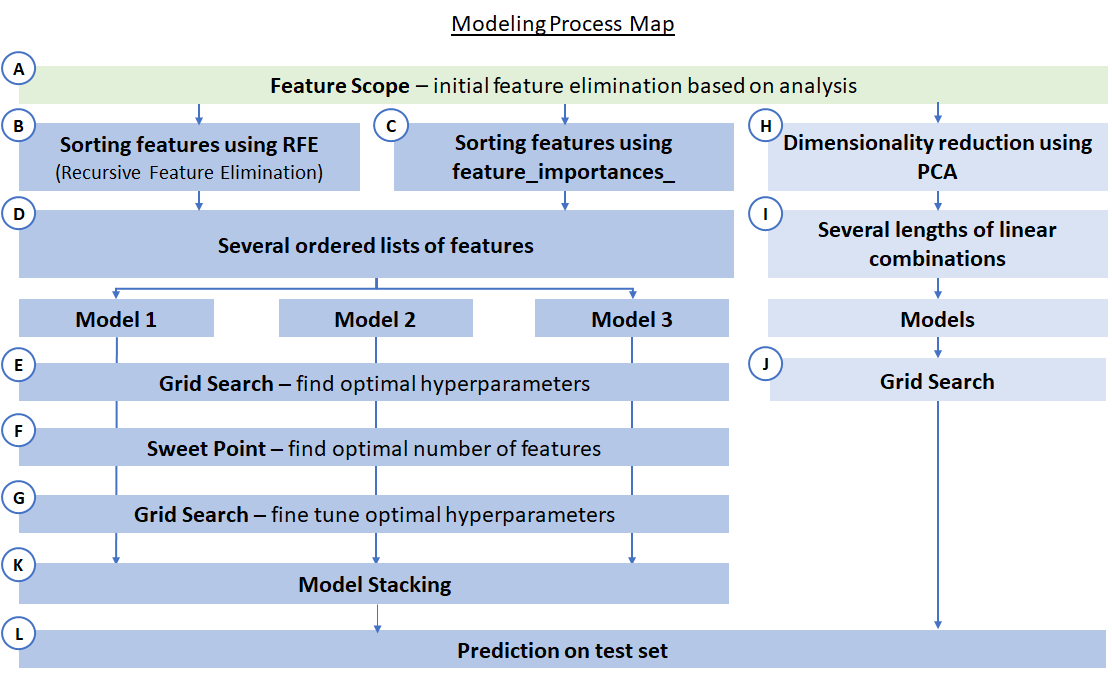

### A. Feature Scope

In [185]:
train_data.shape

(1458, 79)

In [186]:
test_data.shape

(1459, 78)

First I will take out the columns that I will not be using (first wave), and also arranging the data for modeling (Split X and y, get_dummies). After I create the new columns with the dummies, I will run a correlation matrix and look for other features to take away.

In [187]:
valid_data.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive',
       'WoodDeckSF', 'OpenPorchSF'

In [188]:
# Now I will remove all the feature that I found so far as irrelevant or redundant
def drop_irrelevant_redundant_features(df):
    """ Drop several features that were found irrelevant or redundant"""
    
    df = df.drop(["Id", # Of course no need
                  "Utilities", # One value for almost all obserations
                  "Condition1", # IsConditions instead
                  "Condition2", # IsConditions instead
                  "YearBuilt", # HouseAgeRange instead
                  "HouseAge", # HouseAgeRange instead
                  "YearRemodAdd", # IsRemod instead
                  "RemodAge", # IsRemode instead
                  "RealRemodAge", # Was a support column to create IsRemode
                  "RemodType", # Was replaces by IsRemod
                  "KitchenQual", # High correlation to OverallQual
                  "BsmtQual", # High correlation to OverallQual
                  "ExterQual", # High correlation to OverallQual
                  "BsmtFinSF1", # Included in HouseArea
                  "BsmtFinSF2", # Included in HouseArea
                  "BsmtUnfSF", # Included in HouseArea
                  "TotalBsmtSF", #Included in HouseArea 
                  "1stFlrSF", # Included in HouseArea
                  "2ndFlrSF", # Included in HouseArea
                  "LowQualFinSF", # Included in HouseArea
                  "GrLivArea", # Included in HouseArea
                  "TotRmsAbvGrd", # Included in HouseArea
                  "BedroomAbvGr", # Included in HouseArea
                  "BsmtFullBath", # Included in TotalBath
                  "BsmtHalfBath", # Included in TotalBath
                  "FullBath", # Included in TotalBath
                  "HalfBath", # Included in TotalBath
                  "GarageYrBlt", # Correlated with HouseAge
                  "GarageCars", # Correlated with GarageArea
                  "GarageCond", # Has less impact
                  "OpenPorchSF", # Included in TotalPorch
                  "EnclosedPorch", # Included in TotalPorch
                  "3SsnPorch", # Included in TotalPorch
                  "ScreenPorch", # Included in TotalPorch
                  "TotalConditions", # Replaces by IsConditions
                  "MasVnrType", # Covered by the MasVnrTypeNum
                  "QuarterStartDate"], # Was a support column to create 2006_idx
                  axis=1)
    return df
    

In [189]:
drop_irrelevant_redundant_features_transformer = FunctionTransformer(func = drop_irrelevant_redundant_features, validate=False)

In [190]:
valid_data = drop_irrelevant_redundant_features_transformer.transform(valid_data)

In [191]:
def drop_sale_price(df):
    """ Drop SalePrice (dependent variable) to create X_train and X_dev"""
    
    # test_data has no SalePrice column, hence the if condition
    if "SalePrice" in df.columns:
        df = df.drop("SalePrice", axis=1)
    return df

In [192]:
drop_sale_price_transformer = FunctionTransformer(func = drop_sale_price, validate=False)

In [193]:
# Creating y_train before the transformation (that will drop the SalePrice)
y_train = train_data["SalePrice"]

In [194]:
id_test = test_data["Id"] # I will use this column for submission to Kaggle

In [195]:
# Make sure dataframes have the same number of columns
for df in [train_data, test_data]:
    print(df.shape)

(1458, 79)
(1459, 78)


In [196]:
# Making sure also that the dfs have the same columns
for column in test_data.columns:
    if column not in train_data.columns:
        print(column)

I am using the CountVectorizer class to create the dummy variables for the categorical variables. However, this class works onlyy on column/series and not on an entire data frame. Therefore I created the following class that can receive an entire dataframe.

In [197]:
class MyCountVectorizer(TransformerMixin):
    def __init__(self):
        
        self.vector_dict = {} # Store CountVectorizer instance for each object column
        
    def fit(self, df, y=None):
    
        for column in df:
            # Only categorical columns are taken care of
            if df[column].dtype == object:
                count_vectorizer = CountVectorizer(token_pattern=r"(?u)\b\w+\b")
                # Without 'U' it gives me the error: ValueError: np.nan is an invalid document, expected byte or unicode string.
                count_vectorizer.fit(df[column].values.astype('U'))
                self.vector_dict[column] = count_vectorizer
        return self
            
    def transform(self, df):
        
        for column in df:
            # Only categorical columns are taken care of
            if df[column].dtype == object:
                # The array below is a matrix whose columns are the categoris of the original feature 
                vectorized_array = self.vector_dict[column].transform(df[column].values.astype('U'))
                # Turning the array into a dataframe
                vectorized_df = pd.DataFrame(vectorized_array.todense(), columns = self.vector_dict[column].get_feature_names())
                #print("isnull", vectorized_df.isnull().sum().sum())
                #print("len(new)", len(vectorized_df))
                # Since the transformation do not keep the original feature name, I am adding a preface to each category
                for clm in vectorized_df:
                    vectorized_df.rename(columns={clm :column + "_" + clm}, inplace=True)
                # Need to add the new dataframe with the category coloumns of the feature to the original dataframe
                vectorized_df.index = df.index
                df = pd.concat([df, vectorized_df], axis= 1)
                # And take out the old feature
                df.drop(column, axis=1, inplace=True)
                
        return df            

In [198]:
my_count_vect_transformer = MyCountVectorizer()

In [199]:
feature_eng_pipeline = Pipeline([("add_totalconditions", add_totalconditions_transformer),
                                 ("add_isconditions", add_isconditions_transformer),
                                 ("drop_exterior2nd", drop_exterior2nd_transformer),
                                 ("add_house_area", add_house_area_transformer),
                                 ("add_total_bath", add_total_bath_transformer),
                                 ("add_total_porch", add_total_porch_transformer),
                                 ("add_house_age", add_house_age_transformer),
                                 ("add_house_age_range", add_house_age_range_transformer),
                                 ("add_remod_age", add_remod_age_transformer),
                                 ("add_real_remod_age", add_real_remod_age_transformer),
                                 ("add_remod_type", add_remod_type_transformer),
                                 ("add_is_remod", add_is_remod_transformer),
                                 ("add_mas_vnr_type_num", add_mas_vnr_type_num_transformer),
                                 ("add_price_index", add_price_index_transformer),
                                 ("modify_mosold", modify_mosold_transformer),
                                 ("drop_irrelevant_redundant_features", drop_irrelevant_redundant_features_transformer),
                                 ("drop_sale_price", drop_sale_price_transformer),
                                 ("my_count_vect", my_count_vect_transformer)])

In [200]:
feature_eng_pipeline.fit(train_data)

Pipeline(memory=None,
     steps=[('add_totalconditions', FunctionTransformer(accept_sparse=False,
          func=<function add_totalconditions at 0x000002949C32AC80>,
          inv_kw_args=None, inverse_func=None, kw_args=None,
          pass_y='deprecated', validate=False)), ('add_isconditions', FunctionTransformer(accept_s...ed', validate=False)), ('my_count_vect', <__main__.MyCountVectorizer object at 0x000002949C38E828>)])

In [201]:
dfs = [train_data, test_data]
for i, item in enumerate(dfs):
    dfs[i] = feature_eng_pipeline.transform(dfs[i])
X_train, X_test = dfs

In [202]:
# Make sure dataframes have the same number of columns
for df in [X_train, X_test]:
    print(df.shape)

(1458, 242)
(1459, 242)


Now it is the second wave of droping features, when I have all the dummies. I am taking out the variables with high correlation (above 0.8).

In [203]:
# The purpose of this cell is to examine features with high correlation between them, and take out redundant ones accordingly
correlation_matrix = X_train.corr()
threshold = 0.8
list_of_corr_tuples = []
for column in correlation_matrix.columns:
    for value in correlation_matrix[column]:
        # Taking only the values thar are greater than the threshold, also excluding the correlation of features with themselves
        if value > threshold and value !=1:
            idx = correlation_matrix[column][correlation_matrix[column] == value].index[0]
            # column and idx are the names of the features in each intersection
            corr_tuple = (value, column, idx)
            list_of_corr_tuples.append(corr_tuple)
sorted_corr_list = sorted(list_of_corr_tuples, key= lambda tup: tup[0], reverse=True)
sorted_corr_list

[(0.98662165508197308, 'SaleType_new', 'SaleCondition_partial'),
 (0.98662165508197308, 'SaleCondition_partial', 'SaleType_new'),
 (0.92502356978142386, 'HouseStyle_1', 'HouseStyle_5fin'),
 (0.92502356978142386, 'HouseStyle_5fin', 'HouseStyle_1'),
 (0.88542760139806109, 'MiscVal', 'MiscFeature_gar2'),
 (0.88542760139806109, 'MiscFeature_gar2', 'MiscVal'),
 (0.8627976433005965, 'MSZoning_fv', 'Neighborhood_somerst'),
 (0.8627976433005965, 'Neighborhood_somerst', 'MSZoning_fv'),
 (0.83491208751340351, 'RoofStyle_flat', 'RoofMatl_grv'),
 (0.83491208751340351, 'RoofStyle_flat', 'RoofMatl_grv'),
 (0.83491208751340351, 'RoofMatl_grv', 'RoofStyle_flat'),
 (0.83491208751340351, 'RoofMatl_tar', 'RoofStyle_flat'),
 (0.80172831514414189, 'Foundation_slab', 'BsmtCond_basement'),
 (0.80172831514414189, 'Foundation_slab', 'BsmtCond_basement'),
 (0.80172831514414189, 'Foundation_slab', 'BsmtCond_basement'),
 (0.80172831514414189, 'Foundation_slab', 'BsmtCond_basement'),
 (0.80172831514414189, 'Founda

In [205]:
features_to_remove = ['SaleCondition_partial', 'Foundation_slab', 'RoofStyle_flat', 'Neighborhood_somerst', 'MiscVal', 'HouseStyle_5fin']

In [206]:
for df in [X_train, X_test]:
    df.drop(features_to_remove, axis=1, inplace=True)
    print(df.shape)

(1458, 236)
(1459, 236)


### B. Sorting features using RFE (Recursive Feature Elimination)

The RFE algorithm recursively removes features and builds a model on those features that remain. Normally it takes an input of the number of features I want, and receives the most important features in that amount. I wanted to get the priority of features, so I created this function that stores each iteration the most important one and takes it away and so on, till the order is achieved.

In [207]:
def rfe_eliminator(X, y, model):
    """
    The function takes recursively the most important feature, so that a sorted list of columns is achieved.
    input:
    - X: a pandas dataframe with features in each column (after get_dummies)
    - y: a pandas series with the dependent variable values
    - model: an instance of a machine learning class
    The function returns a list of all the features in X, sorted by their importance
    """
    
    sorted_list_of_features = [] # This is where the selected feature is store in each iteration
    for i in tqdm(range(len(X.columns)), desc="Selecting RFE features"):
        rfe = RFE(model, 1) # The RFE class takes as an argument the number of features to return, it is 1 feature each iteration
        rfe_fit = rfe.fit(X, y)
        features_and_rank = list(zip(X.columns, rfe_fit.ranking_)) # Matching the result figures to the column names
        # In the algorithm output the selected features are given the 1 figure
        selected_feature = [tup[0] for tup in features_and_rank if tup[1] == 1] 
        sorted_list_of_features.append(selected_feature[0]) # I am using [0], because the feature comes originally as a list of 1
        X = X.drop(selected_feature[0], axis=1) # Once the feature is selected I don't need it any more in X
    return sorted_list_of_features

### C. Sorting Features Using Feature Importances

Here I am using the feature_importance attributes of random forest to generate the sorted list of columns

In [208]:
def sorted_feature_importance(X, y, model):
    """
    The function runs one of the models with the attribute feature_importances_, and returns a list of sorted features.
    input:
    - X: a pandas dataframe with features in each column (after get_dummies)
    - y: a pandas series with the dependent variable values
    - model: an instance of a machine learning class with feature_importances_ attibute
    The function returns a list of all the features in X, sorted by their importance
    """
    
    model.fit(X, y)
    feat_imp = model.feature_importances_ # Get the feature importance attribute
    list_with_zip = list(zip(X.columns, feat_imp)) # Matching the result figures to the column names
    sorted_importances = sorted(list_with_zip, key=lambda x: x[1], reverse=True)
    sorted_columns_importance = [tup[0] for tup in sorted_importances] # Taking only the names
    return sorted_columns_importance

### D. Several ordered lists of features (using the functions in steps B and C)

In [209]:
# I am using a random forest model to be used with the RFE algorithm, so I give it several combinations of parameters, each
# gives me a different order of features in the rfe_eliminator function (step B) and also for the feature importances (step C)
parameters_rf_regressor = [(30, 8, 3, 1),
                            (30, 6, 3, 1)]#,
#                             (20, 5, 2, 1),
#                             (20, 8, 3, 1),
#                             (10, 7, 4, 2),
#                             (10, 9, 2, 1)]
# Originally I examined all of them

In [210]:
def get_several_feature_lists(X, y, regressor_class, param_for_regressor, sorting_func):
    """
    This function is to be used both for the RFE feature selection and for the feature importance, to generate several 
    ordered lists based on a given regressor and a given set of hyperparameters.
    input:
    - X: a pandas dataframe with features in each column (after dummies)
    - y: a pandas series with the dependent variable values
    - regressor_class: a model class (to be used with random forest and gradient boosting)
    - param_for_regressor: a list of sets of hyperparameters to be used by the regressor_class
    - sorting_func: either the rfe_eliminator and sorted_feature_importance
    The function returns a list of sorted feature lists  
    """
    list_of_sorted_features = []
    # For each set of hyperparameters it instantiates the model and uses the sorting_func to get the features sorted per each
    for i in range(len(param_for_regressor)):
        regressor_for_feature_selection = regressor_class(n_estimators = param_for_regressor[i][0],
                                                                   max_depth = param_for_regressor[i][1],
                                                                   min_samples_split = param_for_regressor[i][2],
                                                                   min_samples_leaf=param_for_regressor[i][3])
        # The following line is the issue - I need the features listed by the importance
        sorted_features = sorting_func(X, y, regressor_for_feature_selection)
        list_of_sorted_features.append(sorted_features)
    return list_of_sorted_features

In [211]:
# Creating different lists of ordered features by RFE
rfe_list_of_lists = get_several_feature_lists(X_train, y_train, RandomForestRegressor,
                                                            parameters_rf_regressor, rfe_eliminator)

A Jupyter Widget

A Jupyter Widget

In [212]:
# Now creating different lists of ordered features by feature importance
feature_importance_list_of_lists = get_several_feature_lists(X_train, y_train, RandomForestRegressor,
                                                            parameters_rf_regressor, sorted_feature_importance)

###  Steps E through H

Steps E through H examine both features ordered by RFE and by feature importance. Also this code is used for running all the models I used: Random Forest, Gradient Boosting, XGBoost, Linear Regression (I just ran this section multiple times with different datasets and models).

### E. Grid Search 

In [213]:
# Picks one of the feature lists of RFE or the 6 lists of feature importances in current run
feature_list = feature_importance_list_of_lists[0]

In [215]:
# Determines the regressor to be used in current run
regressor = GradientBoostingRegressor

In [216]:
# Prepare parameters for grid search
parameters = [{'n_estimators': [80,100],
               'max_depth': [4, 5], 
               'min_samples_split': [2,3,4],
               'min_samples_leaf': [2]}] # 'alpha': [0.85, 0.95]

In [217]:
grid_search = GridSearchCV(estimator = regressor(),
                           param_grid = parameters,
                           scoring = 'neg_mean_squared_error',
                           cv =10,
                           verbose = 1)

In [218]:
# Update X_train to have the order according to RFE or feature importance
X_train_reordered = X_train.loc[:, feature_list]

In [219]:
grid_search.fit(X_train_reordered, np.log(y_train))

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  1.8min finished


GridSearchCV(cv=10, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [80, 100], 'max_depth': [4, 5], 'min_samples_split': [2, 3, 4], 'min_samples_leaf': [2]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=1)

In [220]:
# Examine best score
best_accuracy = grid_search.best_score_
abs(best_accuracy)**0.5

0.12225918387089835

In [221]:
# Getting the best parameters to be used for the model
best_parameters = grid_search.best_params_
best_parameters

{'max_depth': 4,
 'min_samples_leaf': 2,
 'min_samples_split': 3,
 'n_estimators': 100}

In [222]:
# Updeting the model with the hyperparameters
model = regressor(n_estimators = 100, max_depth = 4, min_samples_split = 3, min_samples_leaf = 2)

### F. Sweet Point 

The purpose of this step is to find the optimal number of features - to be on the point where there is a balance between the bias and variance error - "the sweet point". At this point the error is the minimal, so I am running the model, each time adding another feature (while the features are ordered by their importance) to get the optimum.

In [223]:
# Setting the interval for getting the results for (every additional X features)
n_features_interval = 5
# Calibration of variables to capture for the best RSME score
best_score = 999
best_score_std = 0
features_for_model = []
score_mean_list = []
score_std_list = []
# The following for loop adds each iteration n_features_interval, examines the score, and if it is the best, it captures the
# result variables
for i in tqdm(range(n_features_interval,len(feature_list), n_features_interval)):
    features_for_cv = feature_list[:i] # adds the features
    x_for_cv = X_train_reordered.loc[:, features_for_cv]
    cv = cross_val_score(model, x_for_cv, np.log(y_train), scoring = 'neg_mean_squared_error', cv =10)
    score_mean = np.mean(np.sqrt(abs(cv)))
    score_std =  np.std(np.sqrt(abs(cv)))
    score_mean_list.append(score_mean)
    score_std_list.append(score_std)
    # Captures the score, std and feature list for lowest RMSE score
    if score_mean < best_score:
        best_score = score_mean
        features_for_model = features_for_cv
        best_score_std = score_std
print("Best RMSE is: {:.3f}".format(best_score))
print("Std for best RMSE is:  {:.3f}".format(best_score_std))
print("Number of features is {}.".format(len(features_for_model)))

A Jupyter Widget


Best RMSE is: 0.120
Std for best RMSE is:  0.018
Number of features is 165.


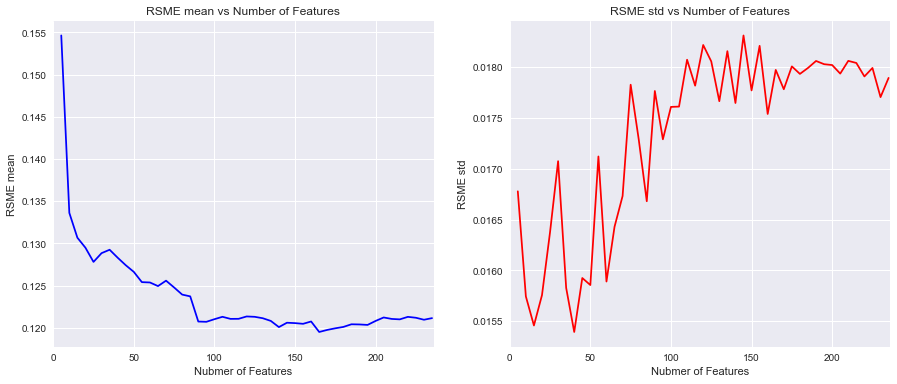

In [224]:
# Total number of features before find_sweet_point
x_range = len(feature_list)

# Resetting the x asix (every tick is a range of features - the axis needs to represent the number of features instead)
x_for_plot = np.arange(n_features_interval, x_range, n_features_interval)
fig = plt.figure(figsize=(15,6))
mean_std_metrics = ["mean", "std"]
# Making two plots, one for the score mean and one for the std
for metric, i, color in zip([score_mean_list, score_std_list], range(2), ["b", "r"]):
    ax = fig.add_subplot(1,2,i+1)
    plt.plot(x_for_plot, metric, color)
    plt.xlabel("Nubmer of Features")
    plt.ylabel("RSME {}".format(mean_std_metrics[i]))
    plt.title("RSME {} vs Number of Features".format(mean_std_metrics[i]))
    plt.xlim(0, x_range)

In [225]:
# features_for_model = feature_list[:120] # For some iteraitons I wanted to force the number of features for comparison

In [226]:
# Number of features for the model
len(features_for_model)

165

### G. Grid Search Fine Tunining 

The second grid search has two purposes: one is to examine the model on the updated feature list (the sweet point), and the second is to further explore the hyperparameters.

In [227]:
# Updating the number of features to take according to the sweet point
X_train_sweet_point = X_train_reordered.loc[:, features_for_model]

In [228]:
parameters = [{'n_estimators': [110, 115, 120],
               'max_depth': [4,5,6], 
               'min_samples_split': [2,3,4],
               'min_samples_leaf': [1,2]}] # 'alpha': [0.89, 0.91, 0.93, 0.95],'learning_rate': [0.09, 0.1, 0.11]

In [229]:
grid_search = GridSearchCV(estimator = regressor(),
                           param_grid = parameters,
                           scoring = 'neg_mean_squared_error',
                           cv = 10,
                           verbose = 1)

In [230]:
grid_search.fit(X_train_sweet_point, np.log(y_train))

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed:  9.1min finished


GridSearchCV(cv=10, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [110, 115, 120], 'max_depth': [4, 5, 6], 'min_samples_split': [2, 3, 4], 'min_samples_leaf': [1, 2]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=1)

In [231]:
grid_search.best_score_

-0.014513397187854542

In [232]:
best_accuracy = grid_search.best_score_
abs(best_accuracy)**0.5

0.12047156173908655

In [233]:
best_parameters = grid_search.best_params_
best_parameters

{'max_depth': 4,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 120}

In [235]:
# Get the STD
grid_search.cv_results_['std_test_score'][grid_search.best_index_]

0.0047670448004414334

In [236]:
# Saving the feature list so I can use it later
pd.Series(X_train_sweet_point.columns).to_csv("model_columns.csv", index=False)

**Cross Validation for Linear Regression**

This sub section is for the linear regression model, where I don't use the grid search.

In [237]:
linear = LinearRegression()

In [238]:
# Updating the number of features to take according to the sweet point
X_for_model = X_train_reordered.loc[:, features_for_model]

In [239]:
cv_folds = 10

In [240]:
# Perform CV
cv_lin = cross_val_score(linear, X_for_model, np.log(y_train), scoring='neg_mean_squared_error', cv=cv_folds)
cv_lin

array([-0.01490288, -0.0110981 , -0.0155205 , -0.01845368, -0.0205214 ,
       -0.00973337, -0.01575392, -0.00948188, -0.0094678 , -0.0167861 ])

In [241]:
# Examine the RMSE results per fold
rmse = np.sqrt(abs(cv_lin))
rmse

array([ 0.12207735,  0.10534754,  0.1245813 ,  0.13584433,  0.14325292,
        0.09865782,  0.12551461,  0.09737494,  0.09730261,  0.12956117])

In [242]:
# Examine the RMSE average
np.mean(rmse)

0.11795145930103072

In [243]:
# Examine the RMSE std
np.std(rmse) / np.sqrt(10)

0.0050932843856887275

### H. Dimentionality Reduction Using PCA

Now I am going to use PCA to create new linear dimentions of the data. First I create a function that creates the new dimentions.

In [244]:
# First scaling
scaler = StandardScaler().fit(X_train)
# I don't use the X_test in this section, but I will have to predict it in case I need to upload to Kaggle results with PCA
dfs = [X_train, X_test]
for i, df in enumerate(dfs):
    dfs[i] = scaler.transform(dfs[i])
X_train_scaled, X_test_scaled = dfs

In [245]:
def pca(X_train_scaled, n_components):
    """The function creates new dimentions DFs for X_train and X_test, based on n_components as number of dimensions"""
    
    pca_trans = PCA(n_components).fit(X_train_scaled)
    X_train_pca = pca_trans.transform(X_train_scaled)
    return X_train_pca

In [246]:
# The three models I am examining with PCA
gb_regressor = GradientBoostingRegressor(alpha = 0.85, n_estimators = 115, max_depth = 4, min_samples_split = 4, min_samples_leaf = 1)
rf_regressor = RandomForestRegressor(n_estimators=35, max_depth=13, min_samples_split=3, min_samples_leaf=2)
ln_regressor = LinearRegression()

In [247]:
models = [gb_regressor, rf_regressor, ln_regressor]
model_names = ["Gradient Boosting", "Random Forest", "Linear Regression"]

### I. Several Lengths of Linear Combinations

For each model, different number of principle components (different linear combinations) gives different result, so I am examining a range of principle components to get the optimum.

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

Text(0,0.5,'RMSE')

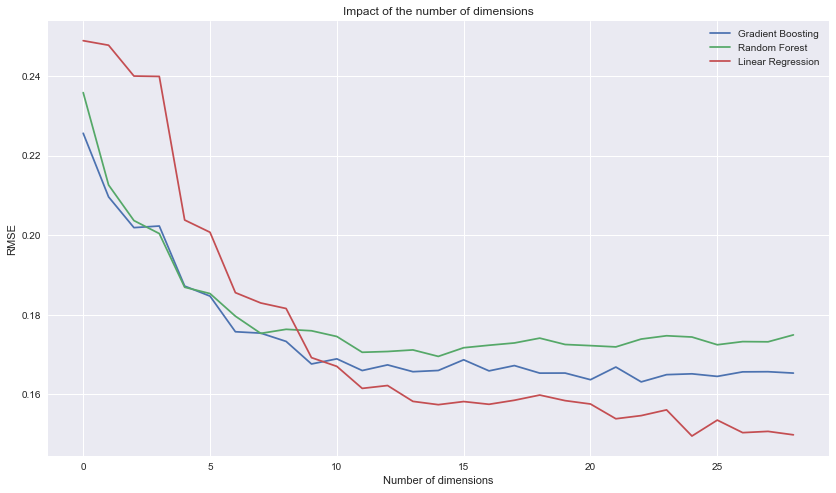

In [248]:
plt.figure(figsize=(14,8))
for model in models:
    list_of_pca_results_for_model = []
    # The for loop takes each iteration a different n of components (dimentions) and runs the model
    for i in tqdm(range(1, 30), desc="{}".format(model_names[models.index(model)])):
        # Creating the PCA matrix for Xs
        X_train_pca = pca(X_train_scaled, i) # Unite lines (DRY)
        # Running the model in cross validation
        cv = cross_val_score(model, X_train_pca, np.log(y_train), scoring = 'neg_mean_squared_error', cv =10)
        pca_result = np.mean(np.sqrt(abs(cv)))
        list_of_pca_results_for_model.append(pca_result)
    # PLotting per model
    plt.plot(list_of_pca_results_for_model, label=model_names[models.index(model)])
plt.legend()
plt.title("Impact of the number of dimensions")
plt.xlabel("Number of dimensions")
plt.ylabel("RMSE")

After running several times, I can see that Linear Regression model is the best of the three. The natural thing to do would be to examine a range of values for ceah model, however I see that the RMSE is much higher than the results I got without the PCA, so I will examine only one value of number of dimentions for each model.

### J. Grid Search and Prediction

I am running this step on each one of the models.

In [249]:
# Number of dimensions (different for each model)
n_dimensions = 14

In [250]:
X_train_pca_model = pca(X_train_scaled, n_dimensions)

In [251]:
regressor = RandomForestRegressor

In [252]:
parameters = [{'n_estimators': [25, 30], 
               'max_depth': [8,10,12],
               'min_samples_split': [3,4],
               'min_samples_leaf': [2,1]}] # 'alpha': [0.75, 0.85]

In [253]:
grid_search = GridSearchCV(estimator = regressor(),
                           param_grid = parameters,
                           scoring = 'neg_mean_squared_error',
                           cv = 10,
                           verbose = 1)

In [254]:
grid_search.fit(X_train_pca_model, np.log(y_train))

Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:   40.7s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [25, 30], 'max_depth': [8, 10, 12], 'min_samples_split': [3, 4], 'min_samples_leaf': [2, 1]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=1)

In [255]:
grid_search.best_params_

{'max_depth': 10,
 'min_samples_leaf': 2,
 'min_samples_split': 3,
 'n_estimators': 25}

In [256]:
# Get RMSE
best_accuracy = grid_search.best_score_
abs(best_accuracy)**0.5

0.17117973973337916

**Cross validation**

In [260]:
model = RandomForestRegressor(n_estimators = 25,
                                      max_depth = 10,
                                      min_samples_split = 3,
                                      min_samples_leaf = 2)#,
                                      #alpha=0.85)

In [261]:
cv_folds = 10

In [262]:
# This cell is for the linear regressor where I don't use grid search
reg_cv = cross_val_score(model, X_train_pca_model, np.log(y_train), scoring='neg_mean_squared_error', cv=cv_folds)
np.mean(np.sqrt(abs(reg_cv)))

0.17289935026573172

In [263]:
# Get the STD
np.std(np.sqrt(abs(reg_cv))) / np.sqrt(cv_folds)

0.0056155443195803423

### K. Model Stacking

I am using a built in stacking regressor object called **StackingCVRegressor** from a package called **mlxtend**. It receives as input the models to be used on the first level prediction and a meta model for the second level of using the predictions from the first level.

In [264]:
# Detailing the three base models to be stacked
linear_for_staking = LinearRegression()
xgb_for_stacking = XGBRegressor(n_estimators=120, max_depth=5, gamma=0.01)
grad_boost_for_stacking = GradientBoostingRegressor(n_estimators=130, \
                                       max_depth=4, \
                                       min_samples_split=3, \
                                       min_samples_leaf=2, \
                                       alpha=0.78, \
                                       learning_rate=0.11)
# The meta model to be used for stacking (after several experiments of model and hyperparameters)
meta_model = SVR(kernel='linear', C=10)

# The StackingCVRegressor uses scikit-learn's check_cv internally, which doesn't support a random seed. Thus, NumPy's random
# seed need to be specified explicitely for deterministic behavior
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
stack = StackingCVRegressor(regressors=(linear_for_staking, xgb_for_stacking, grad_boost_for_stacking), meta_regressor=meta_model)

When I built each one of the single models, I used a different set of features for each one (different features and different number of features). However, the StackingCVRegressor (as far I understand), does not support different sets of features for the different models, so I am trying to find the optimal number of features to get the best score.

In [265]:
# The following two lines set the boundaries for examining the number of features
X_n_features = X_train_reordered.shape[1] # The maximum number of features
min_features_to_check = 100 # The minimum for examinatiob
# The next 4 lines aim to capture the values from the following for loop
best_score = 1
best_std = 0
n_features_for_stacking = 0
score_list = []
# This for loop runs on the number of features (every 10 features), and examines the best score and keeps it
for i in tqdm(range(min_features_to_check, X_n_features, 10)):
    # The stacking regressor must receive np arrays
    X = np.array(X_train_reordered.iloc[:, :i])
    y = np.array(y_train)
    scores = cross_val_score(stack, X, np.log(y), cv=10, scoring='neg_mean_squared_error')
    avg_score = np.mean(np.sqrt(abs(scores)))
    score_list.append(avg_score)
    if avg_score < best_score:
        best_score = avg_score
        best_std = np.std(np.sqrt(abs(scores))) / np.sqrt(10)
        n_features_for_stacking = i
print("Best stacking score: {}".format(best_score))
print("STD for best score: {}".format(best_std))
print("No. of features: {}".format(n_features_for_stacking))

A Jupyter Widget


Best stacking score: 0.10978402890311816
STD for best score: 0.005127241990790006
No. of features: 180


(100, 236)

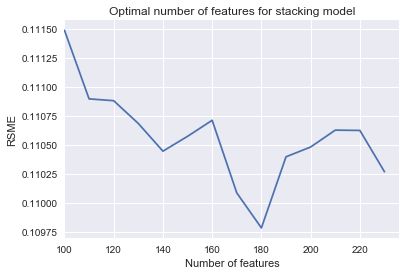

In [266]:
# Plotting the RSME score as a function of the number of features

# Resetting the x asix 
x_for_plot = np.arange(min_features_to_check, X_n_features, 10)

fig = plt.figure()
ax = fig.gca()
ax.plot(x_for_plot, score_list)
ax.set_title("Optimal number of features for stacking model")
ax.set_xlabel("Number of features")
ax.set_ylabel("RSME")
ax.set_xlim(min_features_to_check, X_n_features)

### L. Prediction on X_test

**Prediction by a single model**

In [267]:
# Uploading the list of features to be used
best_features_df = pd.read_csv("model_columns_best.csv", header=None)
n_features = len(best_features_df)
# Extracting the feature list (need the .flat because i get a 2D array)
feature_list_best = list(best_features_df.values.flat)

In [268]:
for feature in feature_list_best:
    if feature not in list(X_train.columns):
        print(feature)

In [269]:
# Making sure that the number of features is correct
n_features

80

In [270]:
# Updating the features to be used by X_train and X_test
X_train_for_submission = X_train.loc[:, feature_list_best]
X_test_for_submission = X_test.loc[:, feature_list_best]

In [271]:
# Assign the best hyperparameters
best_model = GradientBoostingRegressor(n_estimators = 116,
                                      max_depth = 4,
                                      min_samples_split = 4,
                                      min_samples_leaf = 2,
                                      alpha=0.76)#,
                                      #learning_rate = 0.11)

In [272]:
best_model.fit(X_train_for_submission, np.log(y_train))

GradientBoostingRegressor(alpha=0.76, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=2,
             min_samples_split=4, min_weight_fraction_leaf=0.0,
             n_estimators=116, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [273]:
# Now predicting X_test
pred = best_model.predict(X_test_for_submission)

**Prediction by stacking**

In [274]:
# I have these lines on step E of this chapter, but because I ran it on several models and feature lists, I am repeating it here
# to receive the same results
feature_list = feature_importance_list_of_lists[0]
X_train_reordered = X_train.loc[:, feature_list]
X_test_reordered = X_test.loc[:, feature_list]

In [275]:
# Preparing X_train and X_test for stacking: narrowing the number of features and turning into an array
X_train_for_stack = np.array(X_train_reordered.iloc[:, :180]) # change to n_features_for_stacking
X_test_for_stack = np.array(X_test_reordered.iloc[:, :180]) # change to n_features_for_stacking
y = np.array(y_train)

In [276]:
# Stack is the name of the StackingCVRegressor object I used earlier
stack.fit(X_train_for_stack, np.log(y))

StackingCVRegressor(cv=5,
          meta_regressor=SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
          refit=True,
          regressors=(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False), XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.01, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators...rs=130, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)),
          shuffle=True, store_train_meta_features=False,
          use_features_in_secondary=False)

The purpose of running the cross validation now is to present the variability in the scores received. It is important because it may explains the differnce between the result I get (the average of the CV), and the score in Kaggle, which is not as good as the average.

In [277]:
cv = cross_val_score(stack, X_train_for_stack, np.log(y), cv=10, scoring='neg_mean_squared_error')

<a id='cv_sqrt_best'></a>

In [278]:
# Getting the sqrt
cv_sqrt = np.sqrt(abs(cv))
cv_sqrt

array([ 0.11308174,  0.09325381,  0.11095867,  0.12461487,  0.14538564,
        0.09423032,  0.10903756,  0.09750668,  0.08987045,  0.12297582])

**It can clearly be seen that although the mean is relatively low (0.1095), some of the figures are much higher. The average of the worst 5 scores out of 10 is 0.122 - which is roughly the score in Kaggle's leaderboard.**

In [279]:
# Now making the prediction on X_test
pred = stack.predict(X_test_for_stack)

**Continue for either a single model or stacking**

In [280]:
# The result received is a logged, and I turn it into a series to concatenate to X_test. Also need the id for the submission file
pred_series = pd.Series(pred, name="SalePriceLog") 
pred_series.index = X_test.index # I need to match the index of X_test and pred_series before concatenating
test_data_with_price = pd.concat([X_test, id_test, pred_series], axis= 1)
test_data_with_price.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,KitchenAbvGr,Fireplaces,GarageArea,WoodDeckSF,...,SaleType_new,SaleType_oth,SaleType_wd,SaleCondition_abnorml,SaleCondition_adjland,SaleCondition_alloca,SaleCondition_family,SaleCondition_normal,Id,SalePriceLog
0,20,80.0,11622,5,6,0.0,1,0,730.0,140,...,0,0,1,0,0,0,0,1,1461,11.741297
1,20,81.0,14267,6,6,108.0,1,0,312.0,393,...,0,0,1,0,0,0,0,1,1462,12.006703
2,60,74.0,13830,5,5,0.0,1,1,482.0,212,...,0,0,1,0,0,0,0,1,1463,12.097276
3,60,78.0,9978,6,6,20.0,1,1,470.0,360,...,0,0,1,0,0,0,0,1,1464,12.176780
4,120,43.0,5005,8,5,0.0,1,0,506.0,0,...,0,0,1,0,0,0,0,1,1465,12.179360


In [281]:
# Unlog
test_data_with_price["SalePrice"] = np.exp(test_data_with_price["SalePriceLog"])

In [282]:
# Preparing the file for submission per Kaggle's requirement.
df_for_sumbission = test_data_with_price[["Id","SalePrice"]]
df_for_sumbission.head()

,Id,SalePrice
0,1461,125655.206065
1,1462,163849.482333
2,1463,179382.522487
3,1464,194226.392558
4,1465,194728.116253


In [283]:
df_for_sumbission.to_csv("house_prices_submission_32.csv", index=False)

<a id='Result Summary'></a>
## Result Summary
[Back to top](#content)

**Models and parameters**

After all the runs, the best result (lowest RMSE) I got was **RMSE = 0.1095**, achieved by stacking under the following conditions:
- Initial features (after count vectorizer) were ordered according to feature importance, by using (see step D in the modeling section):
  - Random Forest Feature importance (parameters: n_estimators=30, max_depth=8, min_sample_split=3, min_sample_leaf=1)
  - Order by RFE (parameters: n_estimators=30, max_depth=6, min_sample_split=3, min_sample_leaf=1)
  
  
- The next step was to select models. 3 models were used:
  1. **Gradient Boosting**:
     - The first 145 features from the RFE were selected to the model
     - Parmaters used: alpha: 0.78, n_estimators=130, max_depth=4, min_sample_split=3, min_sample_leaf=2, learning_rate = 0.11
  2. **XGBoost**:
     - The first 120 features from the feature selection were selected to the model
     - Parameters used: n_estimators=120, max_depth=5, gamma = 0.01
  3. **Linear Regression (simple model)**
  
  
- Then a stacking model was built, using **StackingCVRegressor** from the mlxtend package.
   - Meta model used: SVR (parameters: kernel='linear', C=10)
   - First 180 features

In [284]:
# Uploading the results I captured in the modeling phase
result_data = pd.read_csv("house_prices_result_summary.csv")
result_data["num"] = list(range(len(result_data)))

In [285]:
# See the table of the main models
result_data

,ModelFull,Model,RMSE,Std,num
0,Stack,Stack,0.1095,0.0049,0
1,LN_FI,LN,0.1161,0.0046,1
2,GB_RFE,GB,0.1196,0.0048,2
3,GB_FI,GB,0.1209,0.0051,3
4,RF_FI,RF,0.1350,0.0048,4
5,RF_RFE,RF,0.1370,0.0046,5
6,LN_PCA,LN,0.1530,0.0056,6
7,GB_PCA,GB,0.1650,0.0066,7
8,RF_PCA,RF,0.1710,0.0053,8


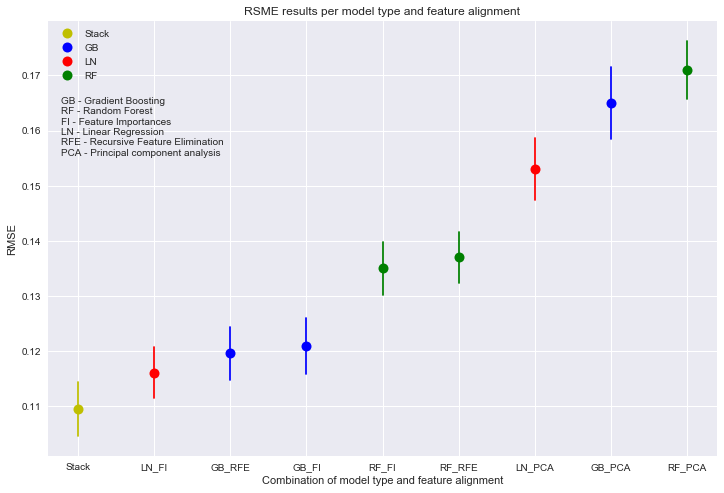

In [286]:
# In this chart I present the best result in each combination of features/models as well as the standard deviation of the cv
color_dict = {"GB": "b", "RF": "g", "LN": "r", "Stack": "y"}
ax = plt.figure(figsize=(12,8)).gca()
models = list(set(result_data["Model"].values))
# Each iteration is a model type (GB, RF, LN)
for value in models:
    sub_result_data = result_data[result_data["Model"] == value] # Subsetting the data for the model type
    ax.plot(sub_result_data["num"], sub_result_data["RMSE"], "." , ms=20, c=color_dict[value], label = value)
    # The next three lines are for ploting the std range
    x_range_std = [sub_result_data["num"], sub_result_data["num"]]
    y_range_std = [sub_result_data["RMSE"]-sub_result_data["Std"], sub_result_data["RMSE"]+sub_result_data["Std"]] 
    ax.plot(x_range_std, y_range_std, c=color_dict[value])
ax.set_xticks(np.arange(len(result_data)))
ax.set_xticklabels(result_data["ModelFull"])
ax.set_title("RSME results per model type and feature alignment")
ax.set_xlabel("Combination of model type and feature alignment")
ax.set_ylabel("RMSE")
ax.legend()
text_for_chart = """
GB - Gradient Boosting
RF - Random Forest
FI - Feature Importances
LN - Linear Regression
RFE - Recursive Feature Elimination
PCA - Principal component analysis"""
ax.text(0.02, 0.85, text_for_chart, horizontalalignment='left', verticalalignment='top', transform=ax.transAxes)
plt.show()

Some insights:
* The best result recieved is form the stacking model
* There is not much difference between the result received by the RFE feature order and random forest feature imporances.
* PCA models performance is worse than the other feature list based models 

**Prediction Correlation**

In [287]:
X_sub_train, X_dev, y_sub_train, y_dev = train_test_split(X_train_for_stack, y_train, test_size = 0.35)

In [288]:
stack.fit(np.array(X_sub_train), np.array(np.log(y_sub_train)))

StackingCVRegressor(cv=5,
          meta_regressor=SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
          refit=True,
          regressors=(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False), XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.01, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators...rs=130, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)),
          shuffle=True, store_train_meta_features=False,
          use_features_in_secondary=False)

In [289]:
pred_dev = stack.predict(X_dev)

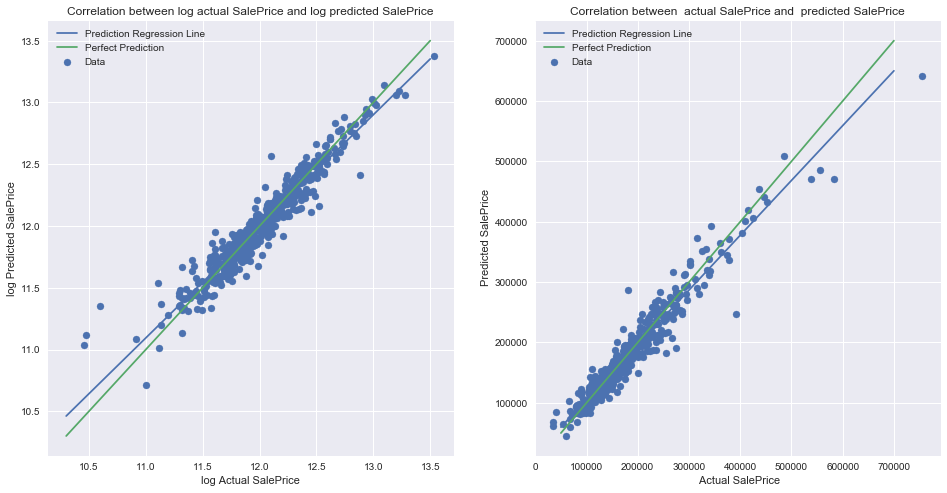

In [290]:
# I am plotting the prediction vs the actual, both for the log values and for the real values. I am adding the regression lines
dev_set = [np.log(y_dev), y_dev]
pred_set = [pred_dev, np.exp(pred_dev)]
regressions = [stats.linregress(dev_set[0], pred_set[0]), stats.linregress(dev_set[1], pred_set[1])]
log_for_title = ['log', ""]
# Inputs for the regression lines edges
x0 = [10.3, 50000]
x1 = [13.5, 700000]

fig = plt.figure(figsize=(16,8))
# Subplot for each one of the i's
for i in range(2):
    # Regression line formula
    slope_log, intercept_log, r_value_log, p_value_log, std_err_log = regressions[i]
    # Regression line edges
    y0 = slope_log * x0[i] + intercept_log
    y1 = slope_log * x1[i] + intercept_log
    ax = fig.add_subplot(1,2,i+1)
    ax.scatter(dev_set[i], pred_set[i], label="Data")
    ax.plot([x0[i], x1[i]], [y0, y1], label="Prediction Regression Line") # The regression line
    ax.plot([x0[i], x1[i]], [x0[i], x1[i]], label="Perfect Prediction") # The perfect prediction line
    ax.set_title("Correlation between {0} actual SalePrice and {0} predicted SalePrice".format(log_for_title[i]))
    ax.set_xlabel("{} Actual SalePrice".format(log_for_title[i]))
    ax.set_ylabel("{} Predicted SalePrice".format(log_for_title[i]))
    ax.legend()
plt.show()

I can see that in general the model tends to over prediction for low sale price (most houses are above the perfect prediction line) and for under predeiction for high sale price (most houses are below the perfect prediction line).

**Benchmark**

To date (May 31 2018), there are 5433 teams that submitted the House Price Competition. In the next chart I present the scores acieved by the first 5000 teams (beyond it the scores strat to become too high for the plot). I also took out the original first 5 on the leaderboard, because they have suspiciously very low score (3 of them have zero error).

In [292]:
leaderboard = pd.read_csv("publicleaderboard.csv")
leaderboard.head()

,Name,Num,Score
0,Breogán Cid Díaz,1,0.00038
1,ericbenhamou,2,0.00354
2,DSXL,3,0.06626
3,Dan Nilin,4,0.07743
4,Javale,5,0.08397


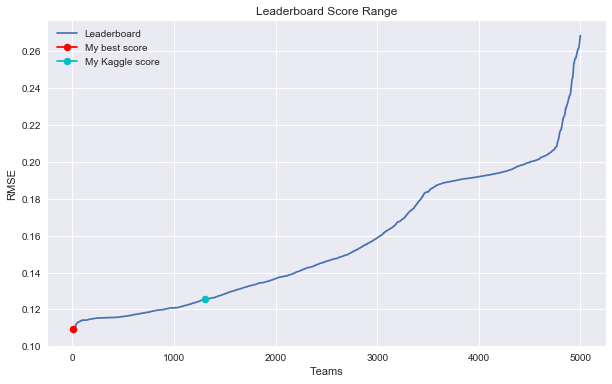

In [293]:
plot_min_lim = 6
plot_max_lim = 5000
my_score_rank = 9
my_score_rsme = 0.1095
kaggle_rank = 1307
kaggle_rmse = 0.1259


ax = plt.figure(figsize=(10,6)).gca()
# Selectiong the limits of scores - the line plot
ax.plot(leaderboard["Num"][plot_min_lim:plot_max_lim], leaderboard["Score"][plot_min_lim:plot_max_lim], label="Leaderboard") 
# Ploting the two points
ax.plot(my_score_rank, my_score_rsme, "r", ms=15, marker=".", label="My best score") # My score
ax.plot(kaggle_rank, kaggle_rmse, "c", ms=15, marker=".", label="My Kaggle score") # My Kaggle score
ax.set_title("Leaderboard Score Range")
ax.set_xlabel("Teams")
ax.set_ylabel("RMSE")
ax.legend()

I believe that the cause for the difference between the best score and Kaggle score is the variability. As one can see [in step L](#cv_sqrt_best) in my modeling section, the CV scores range between 0.100 and 0.157, due to the small dataset as a whole (and around 150 samples per fold). Since the Kaggle leaderboard is based on 50% of the data, this might be the cause.